# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

import torch
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym
import time
from pong_wrapper import PongDeterministic

env = PongDeterministic()

print("List of available actions: ", env.get_action_meanings())

List of available actions:  ['NOOP', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



In [3]:
from pong_helper import PongHelper

# show what a preprocessed image looks like
env.reset()

def some_observations(n):
    return [env.step(env.action_space.sample())[0] for _ in range(n)]

[observation] = some_observations(1)
processed = PongHelper.preprocess(observation)

print(f"observation shape: {observation.shape}, preprocessed shape: {processed.shape}")

observation shape: (210, 160, 3), preprocessed shape: (80, 80)


Text(0.5,1,'Pre-processed')

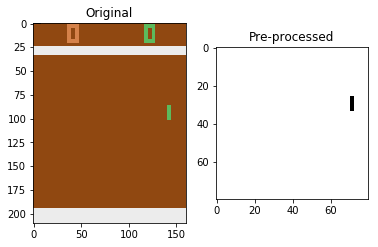

In [4]:
import matplotlib
import matplotlib.pyplot as plt

[observation] = some_observations(1)
processed = PongHelper.preprocess(observation)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(observation)
axes[0].set_title("Original")

axes[1].imshow(processed, cmap='Greys')
axes[1].set_title("Pre-processed")

In [5]:
[obs1, obs2] = some_observations(2)

frames = PongHelper.stack_frames([obs1, obs2])
print(f"frames shape: {frames.shape}")

frames shape: (2, 80, 80)


# Model

## Exercise 1: Implement your model
 
Here, we define our model.

In [6]:
from model import Actor, Critic
import numpy as np

In [7]:
[obs1, obs2, obs3, obs4] = some_observations(4)
stack1 = PongHelper.stack_frames([obs1, obs2])
stack2 = PongHelper.stack_frames([obs3, obs4])

action_size = env.action_space.n
actor = Actor(action_dim=action_size)

states = torch.tensor([stack1, stack2], dtype=torch.float, device=device)
actions, probs = actor.forward(states)
print(f"actions.size(): {actions.size()}")
print(f"actions: {actions}")
print(f"probs.size(): {probs.size()}")
print(f"probs: {probs}")

actions.size(): torch.Size([2, 1])
actions: tensor([[ 1],
        [ 1]])
probs.size(): torch.Size([2, 1])
probs: tensor([[ 0.3317],
        [ 0.3318]])


In [8]:
critic = Critic()
values = critic.forward(states)
print(f"values.size(): {values.size()}")
print(f"values: {values}")

values.size(): torch.Size([2, 1])
values: tensor(1.00000e-02 *
       [[-5.0285],
        [-5.0194]])


# Game visualization
play the game with random agent.

In [9]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)

    fanim = animation.FuncAnimation(plt.gcf(), \
                                    lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)

    display(display_animation(fanim, default_mode='once'))

def play(env, agent, t_max=1000):
    frame = env.reset()
    frame_prev = frame
    anim_frames = []
    score = 0
    for _ in range(t_max):
        state = PongHelper.stack_frames([frame_prev, frame])
        action, prob = agent.act([state])
        frame_prev = frame
        frame, reward, done, _ = env.step(action.item())
        
        anim_frames.append(frame_prev)
        score += reward
        if done:
            break

    env.close()

    animate_frames(anim_frames)
    return score


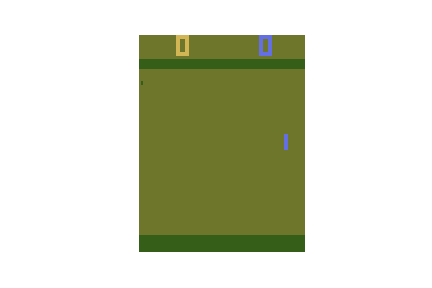
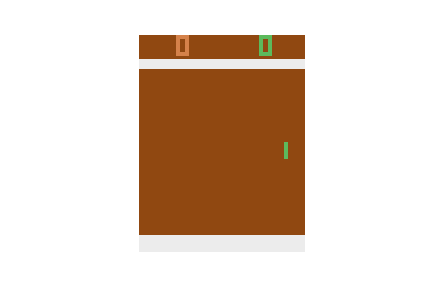
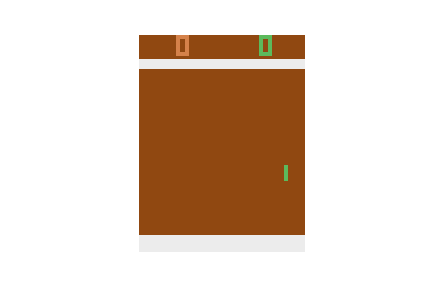
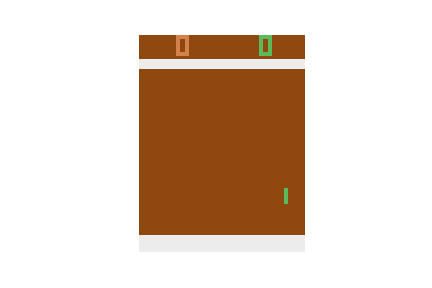
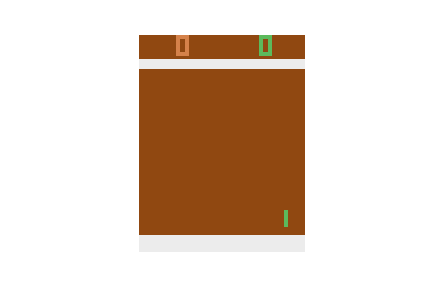
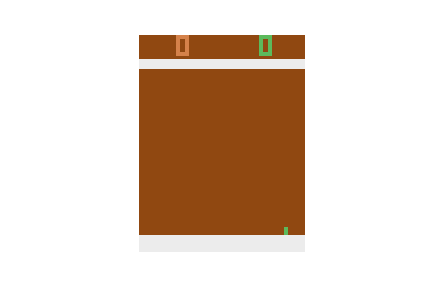
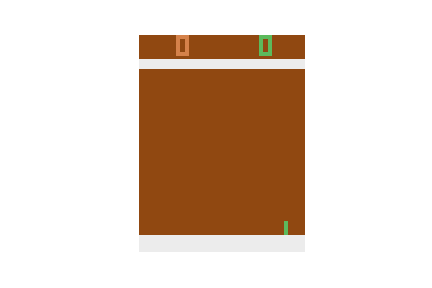
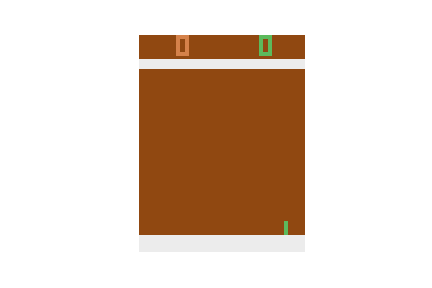
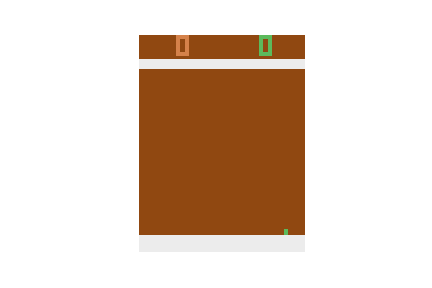
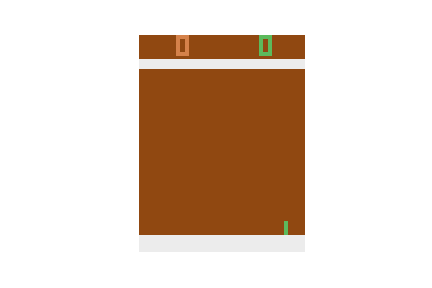
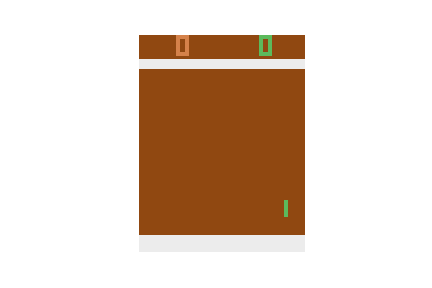
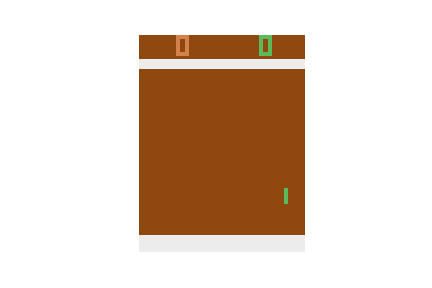
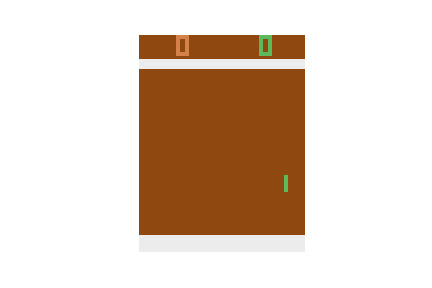
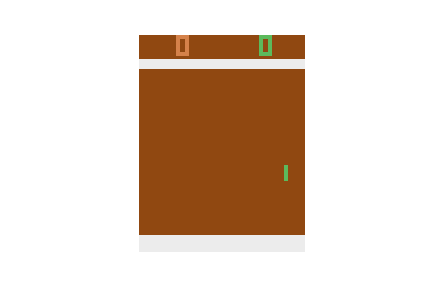
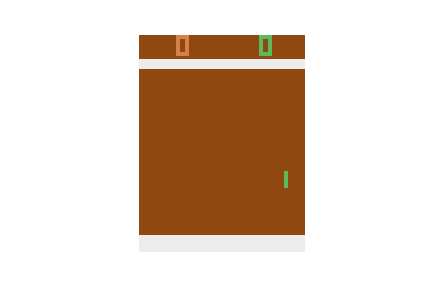
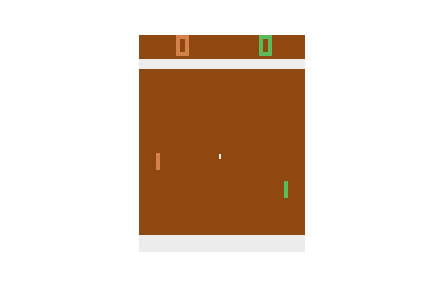
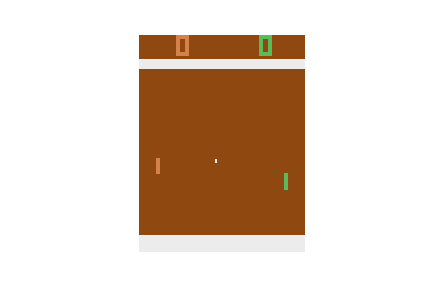
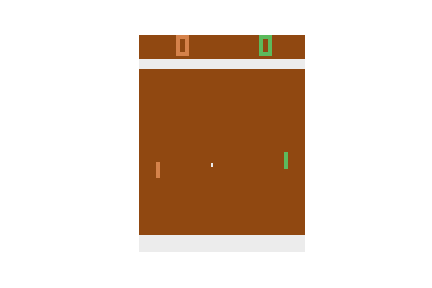
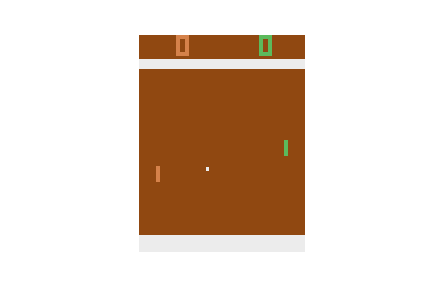
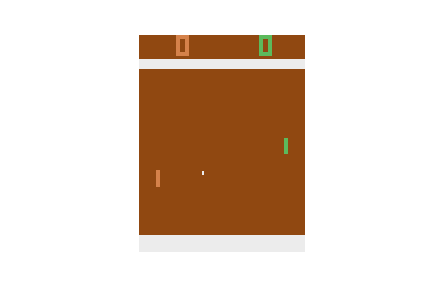
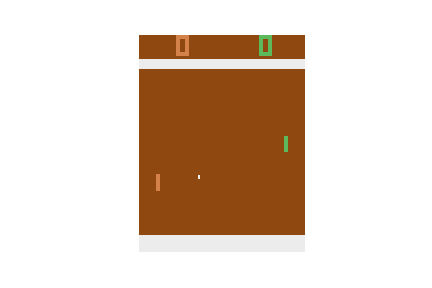
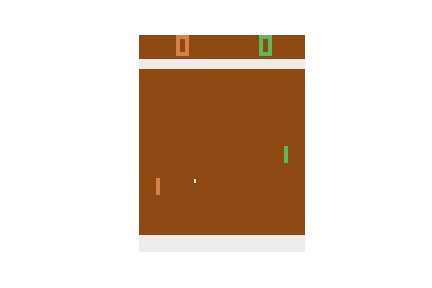
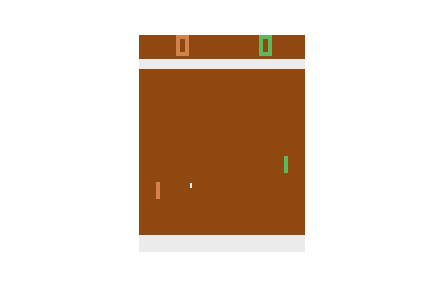
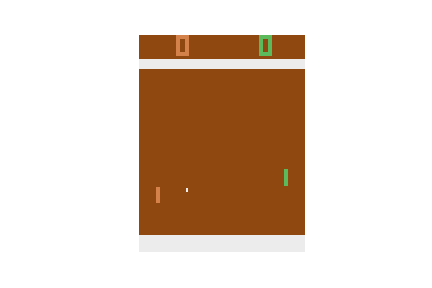
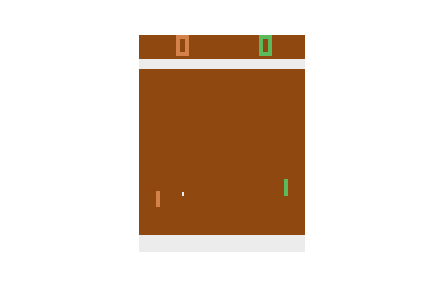
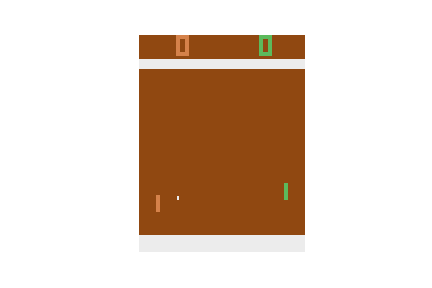
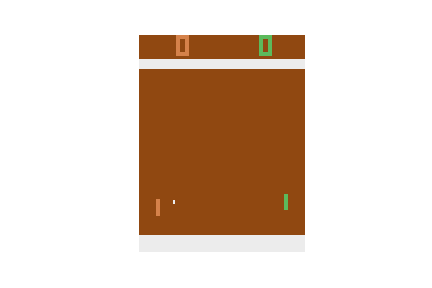
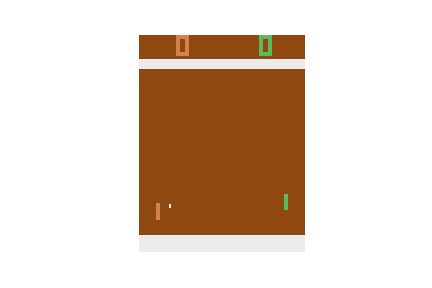
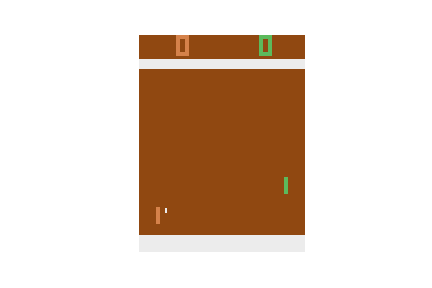
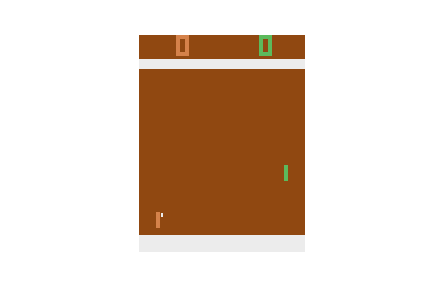
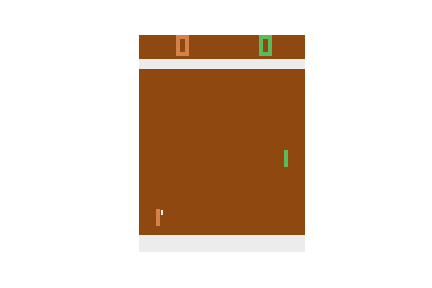
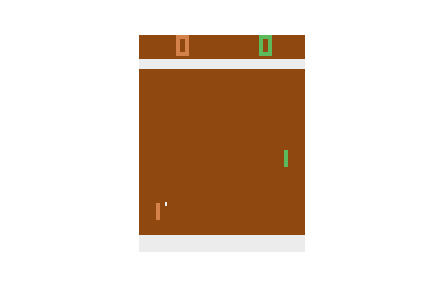
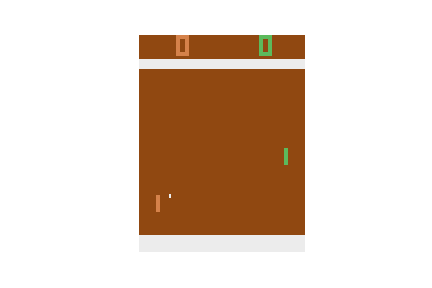
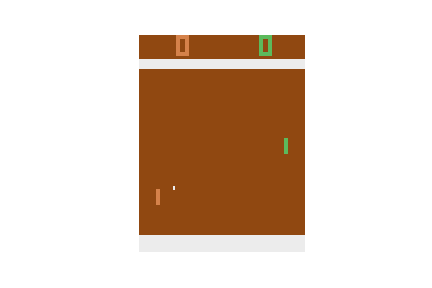
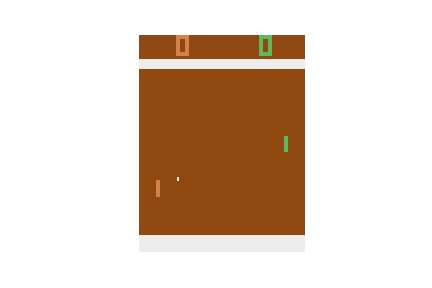
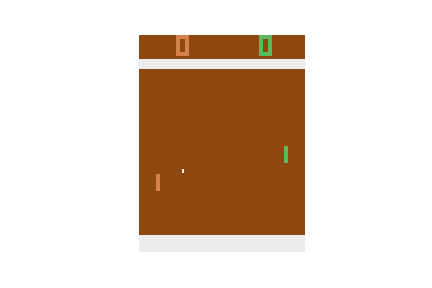
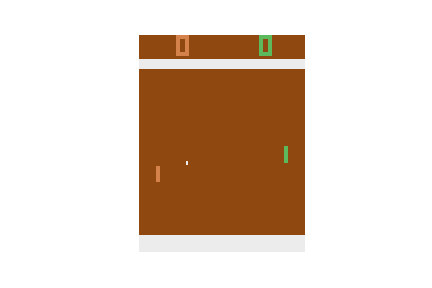
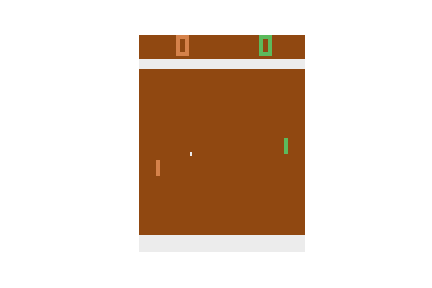
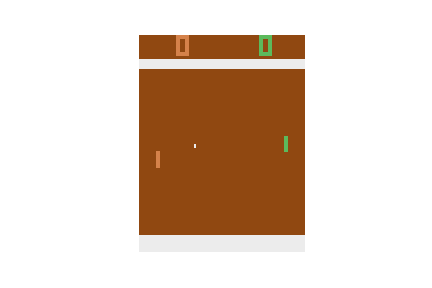
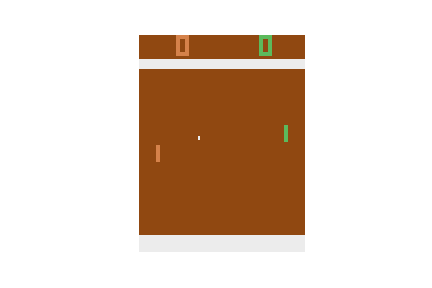
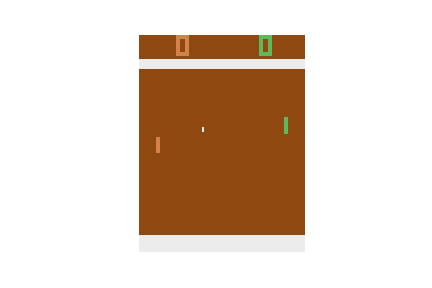
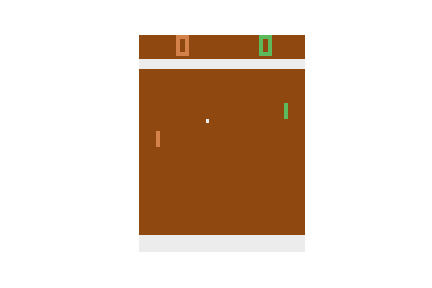
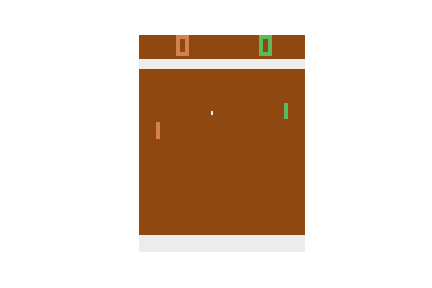
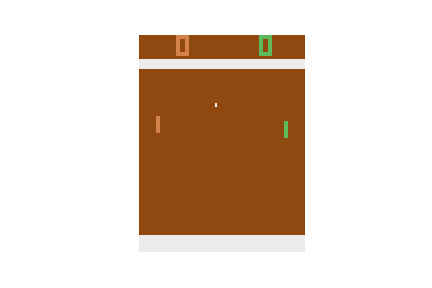
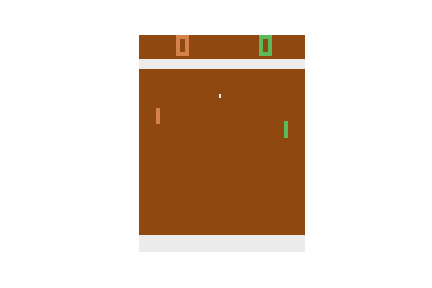
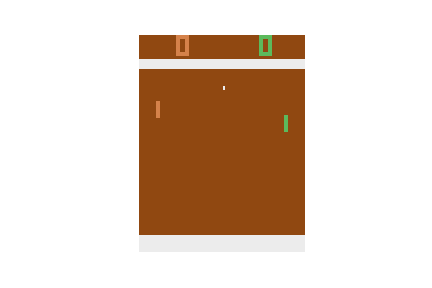
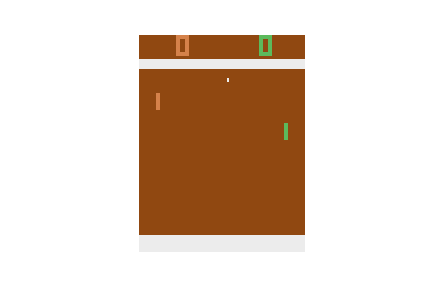
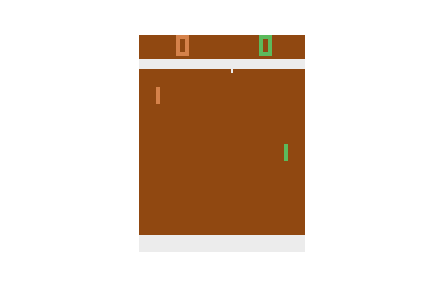
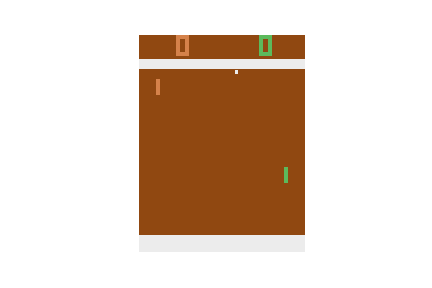
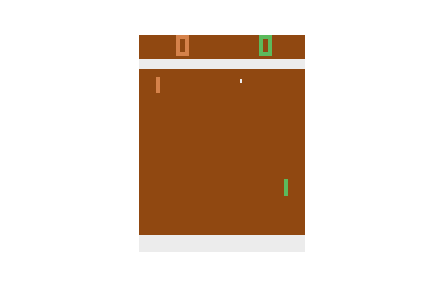
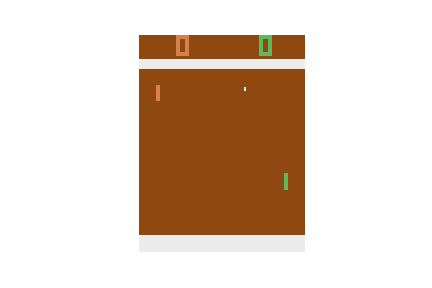
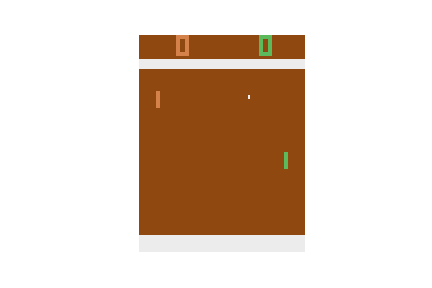
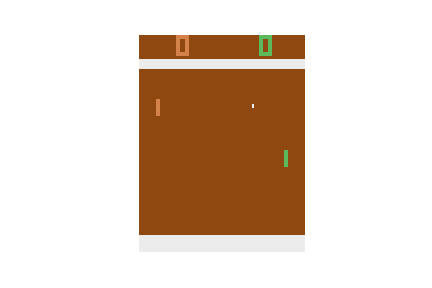
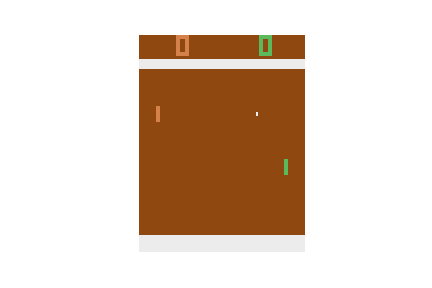
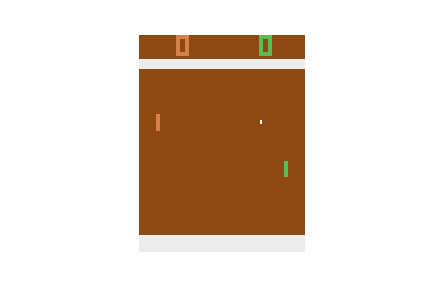
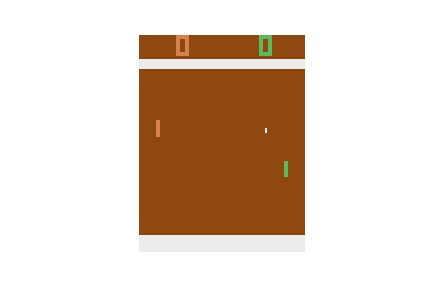
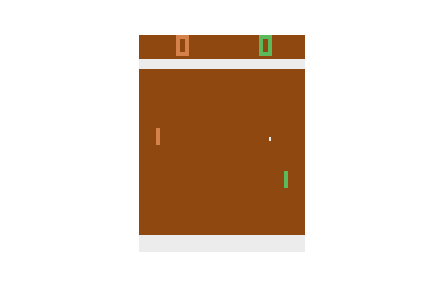
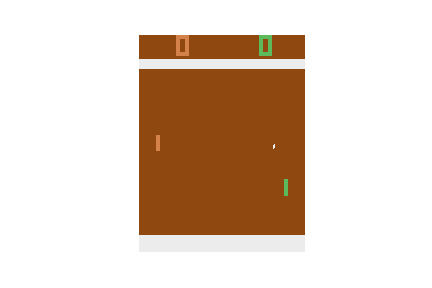
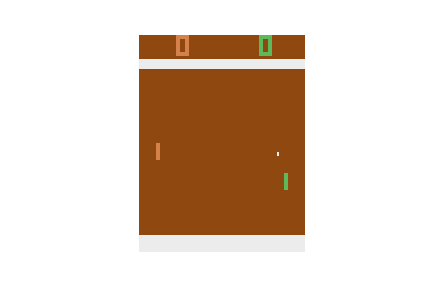
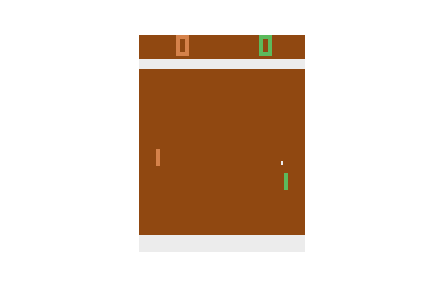
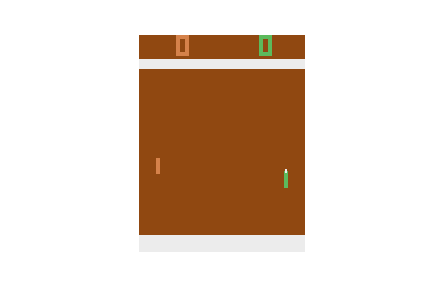
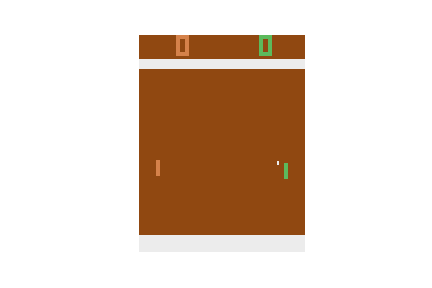
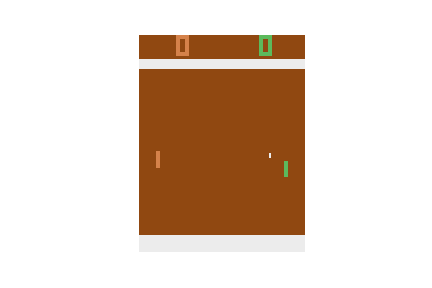
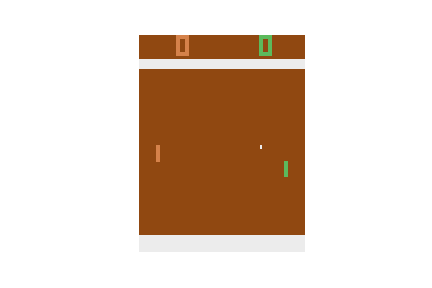
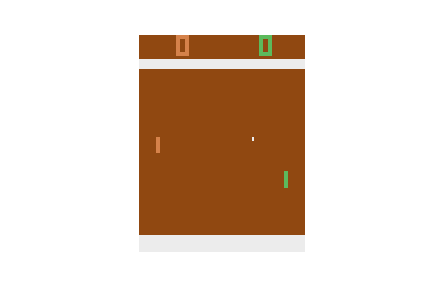
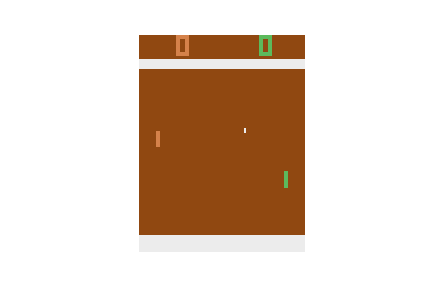
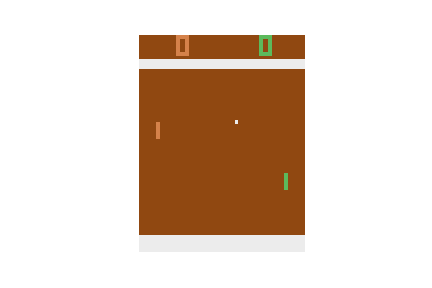
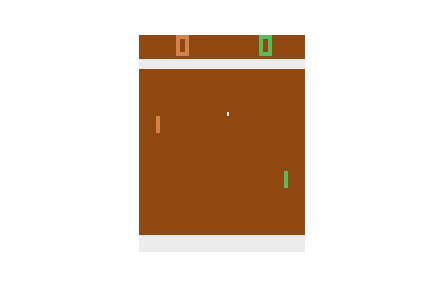
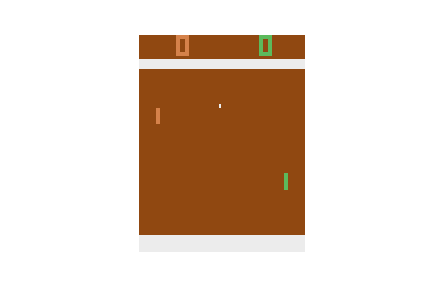
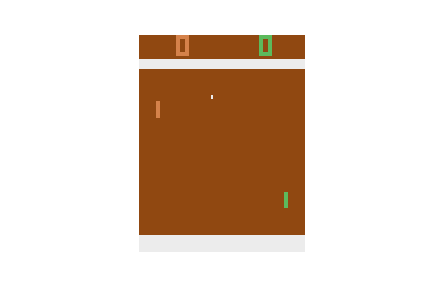
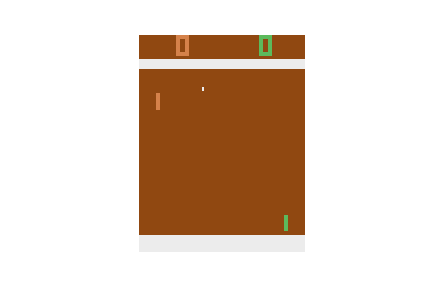
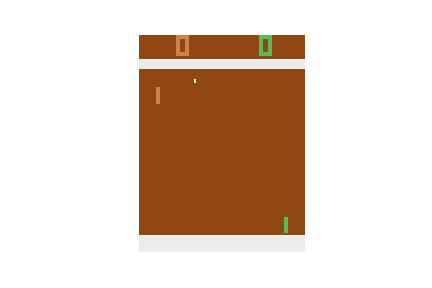
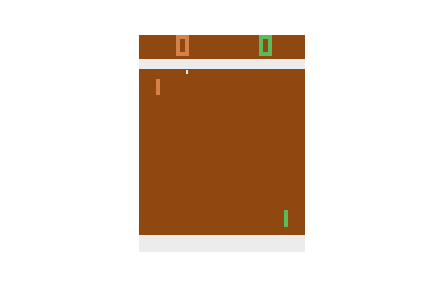
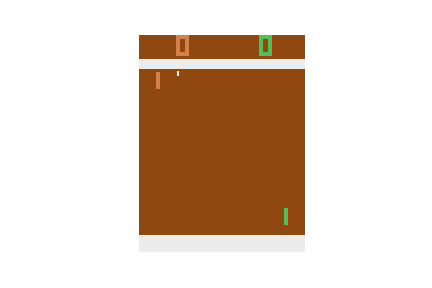
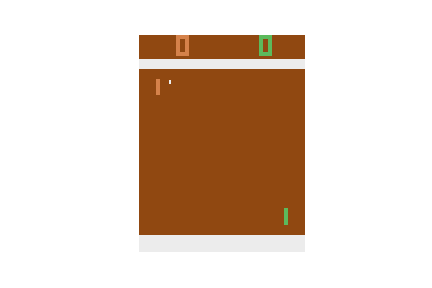
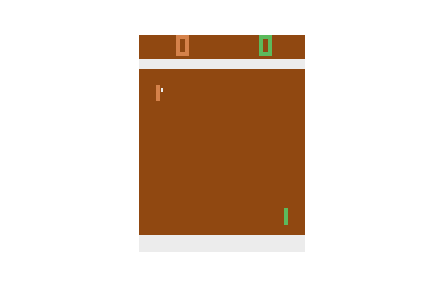
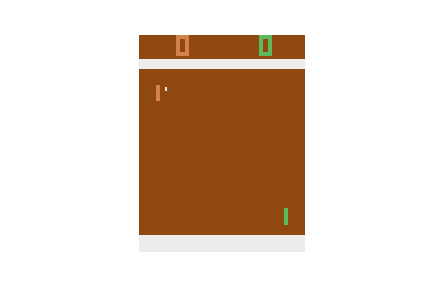
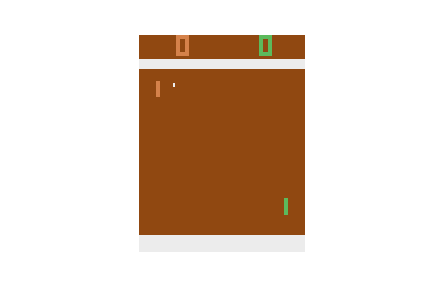
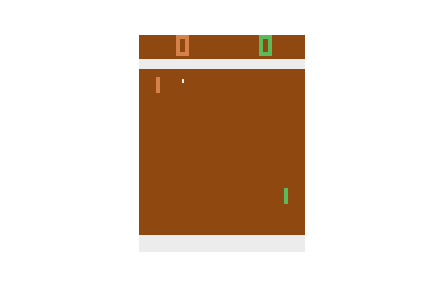
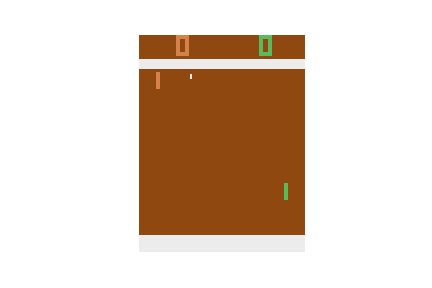
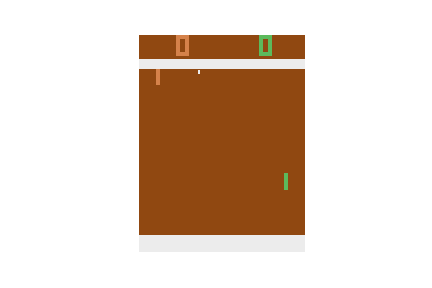
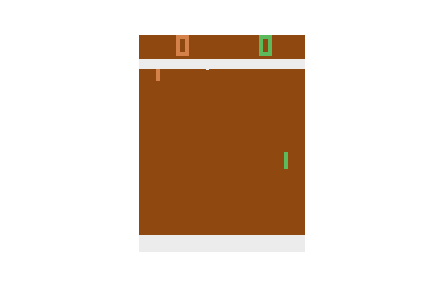
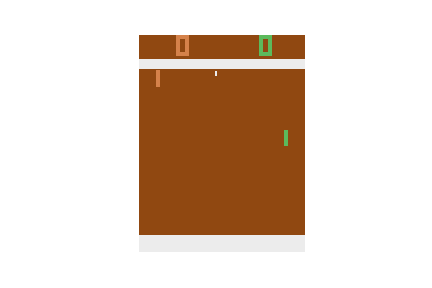
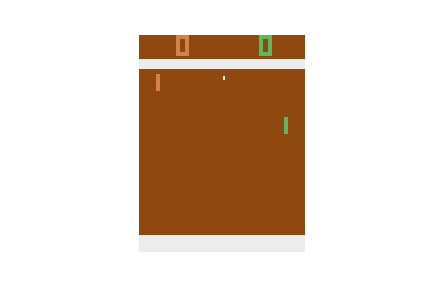
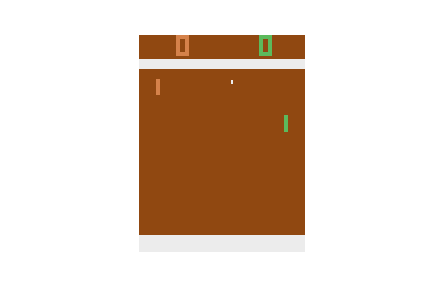
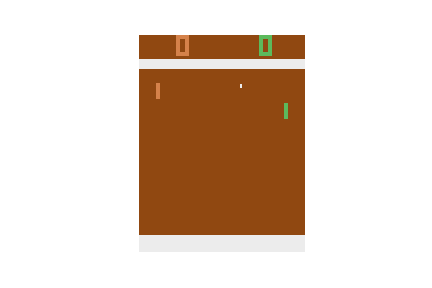
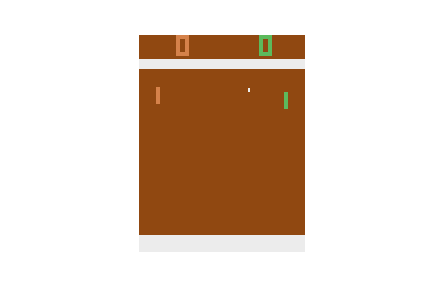
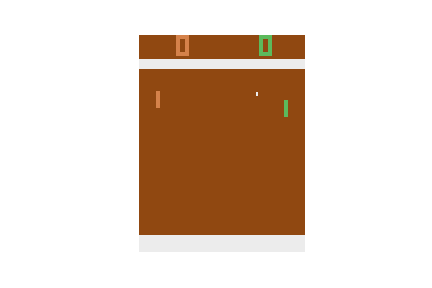
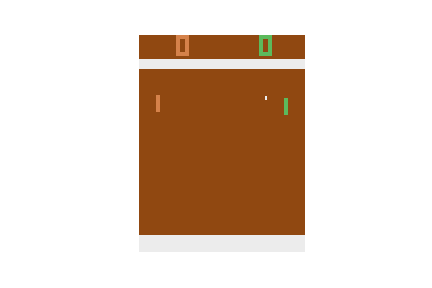
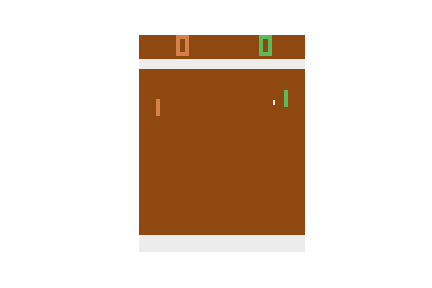
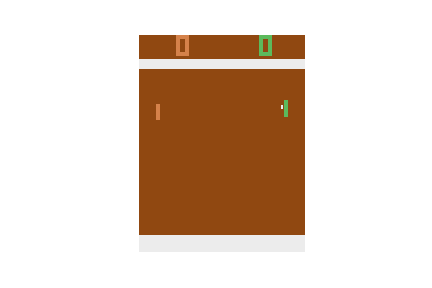
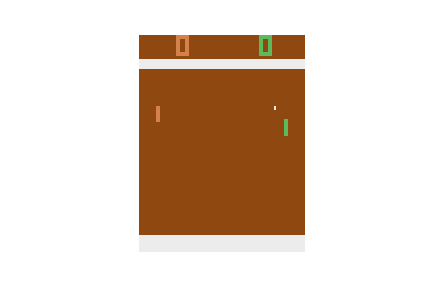
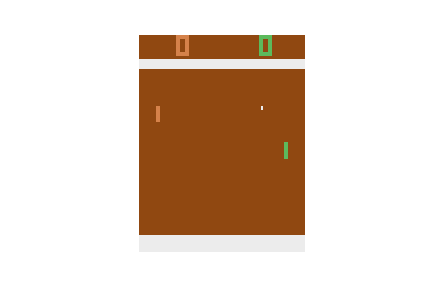
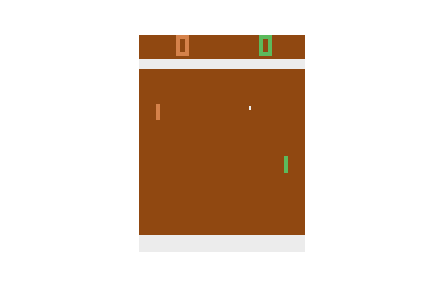
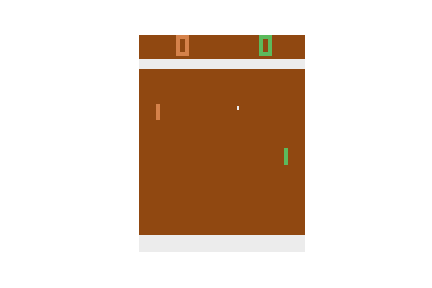
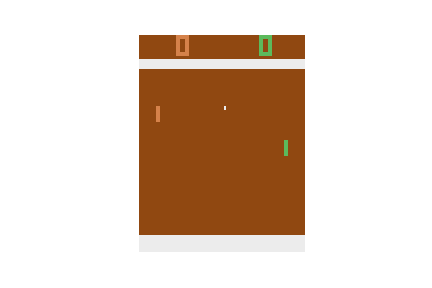
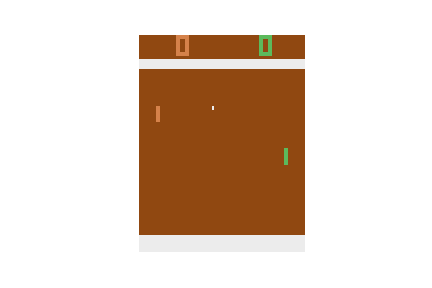
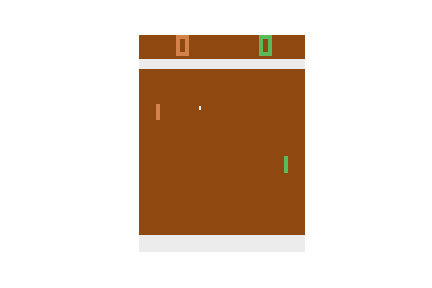
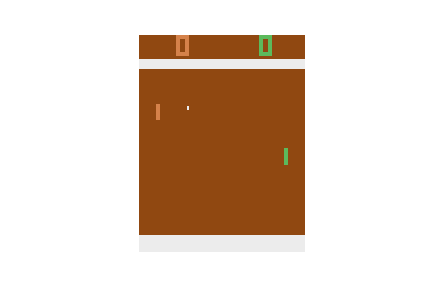
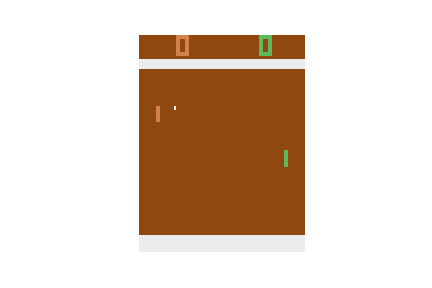
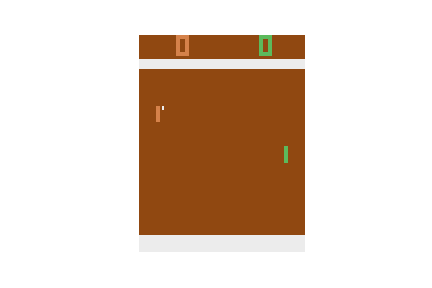
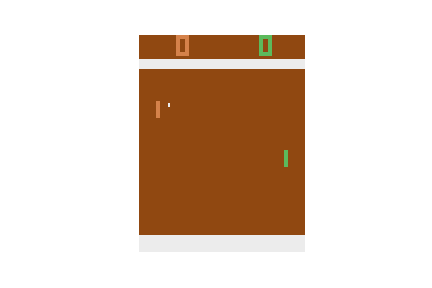
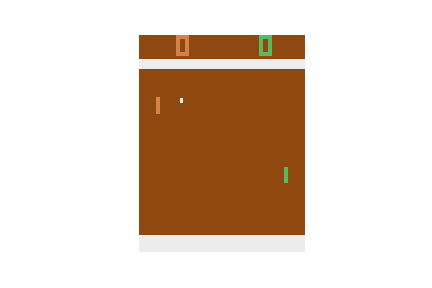
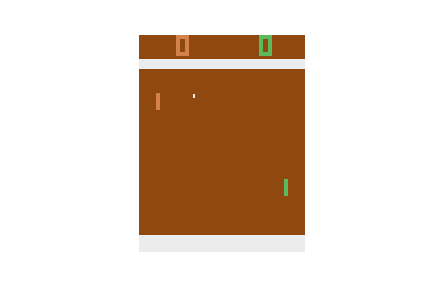
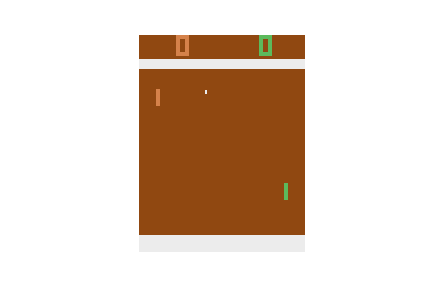
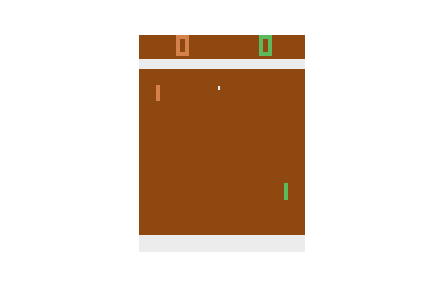
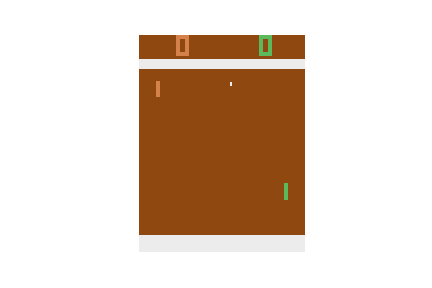
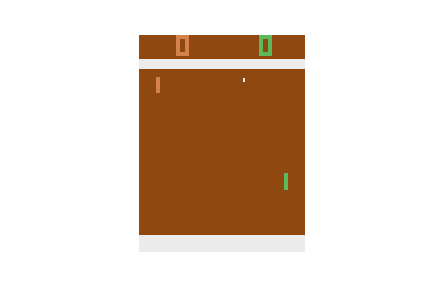
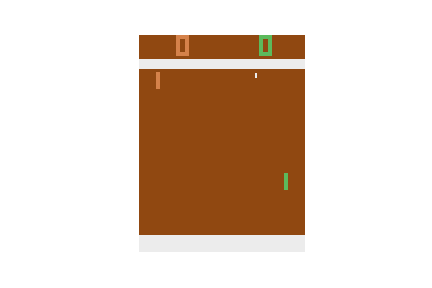
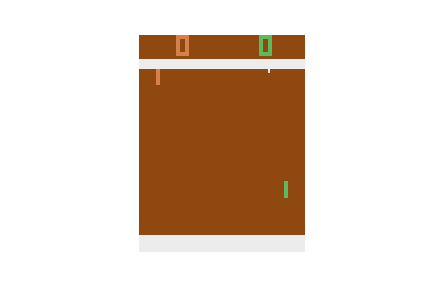
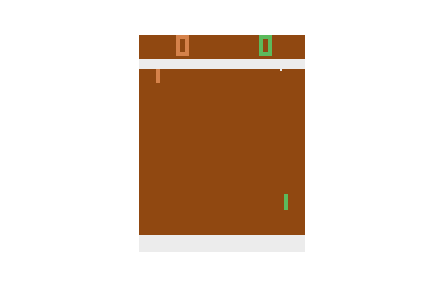
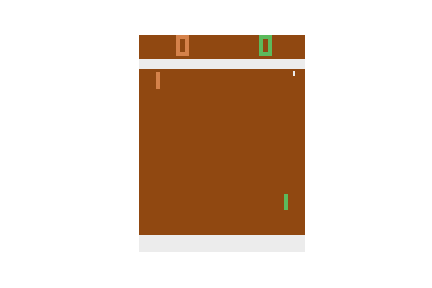
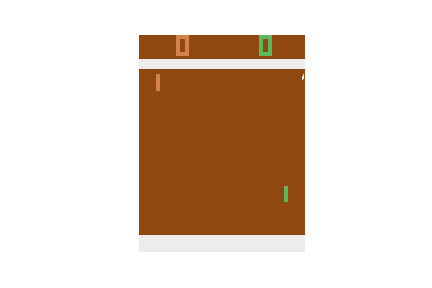
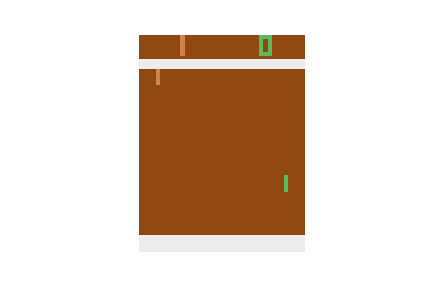
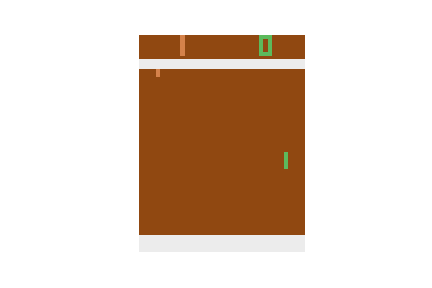
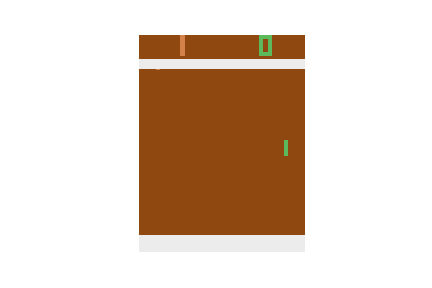
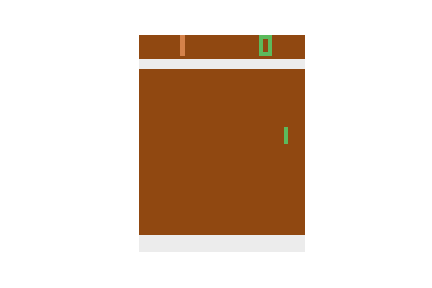
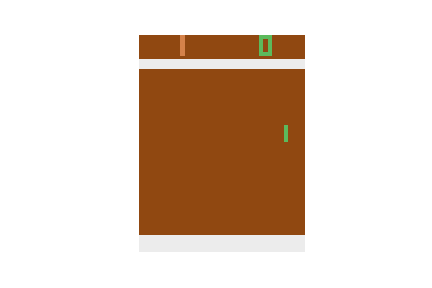
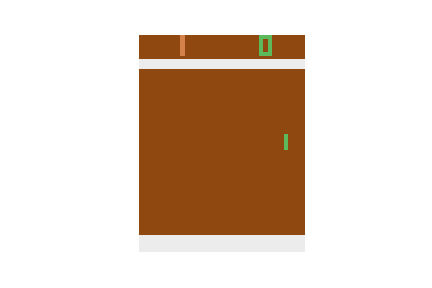
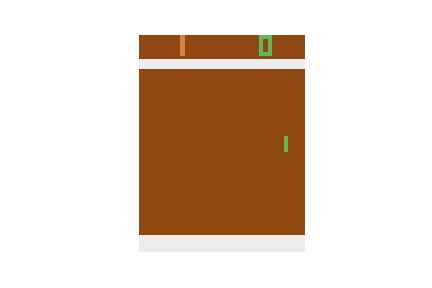
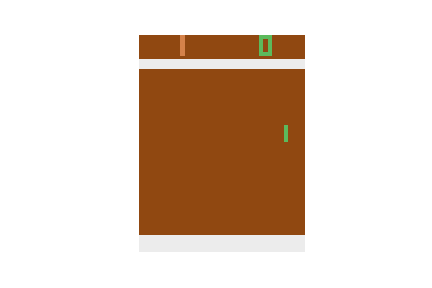
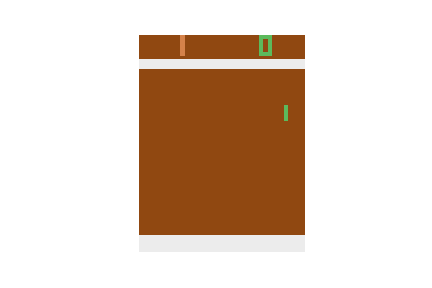
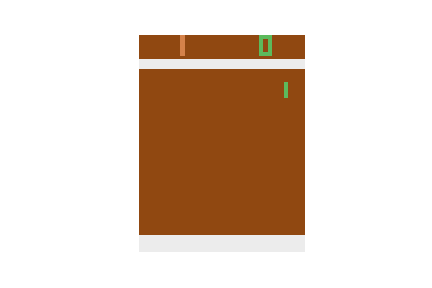
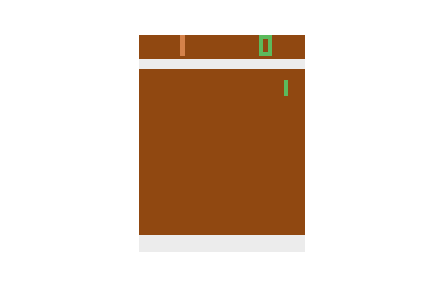
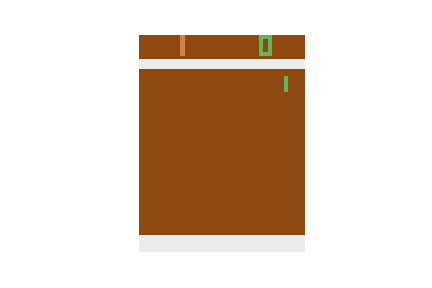
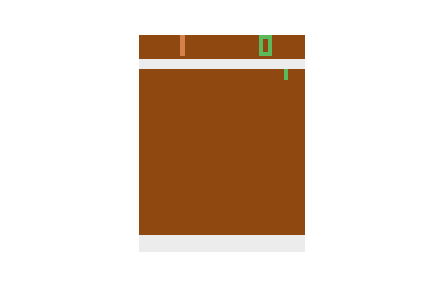
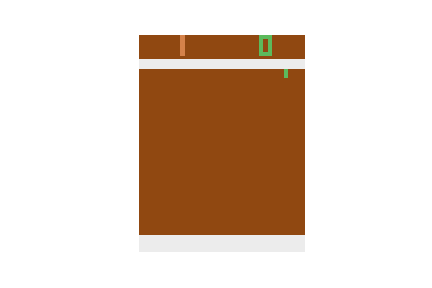
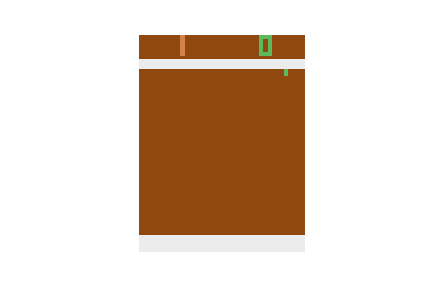
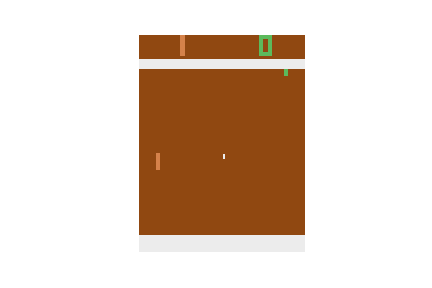
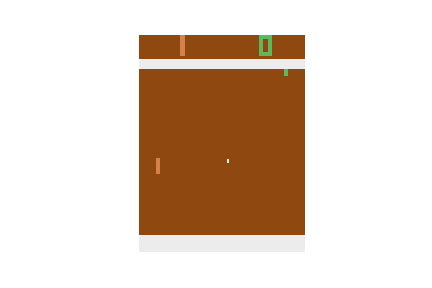
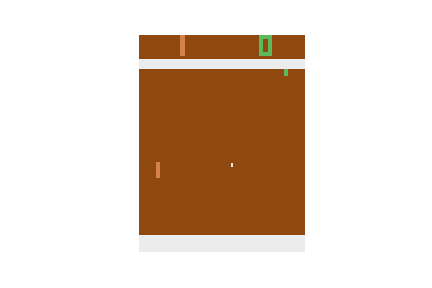
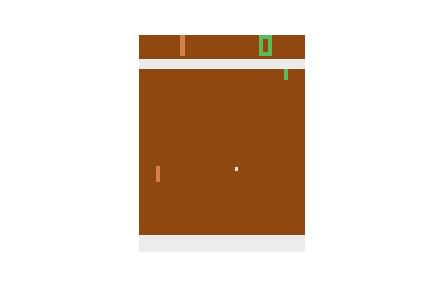
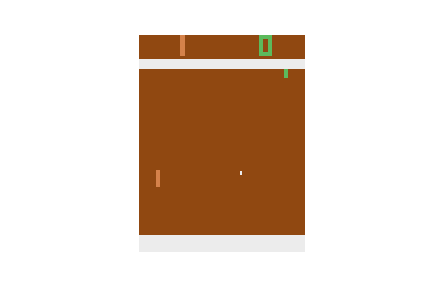
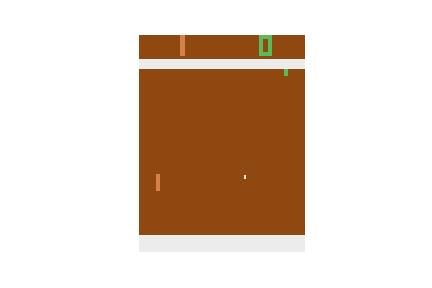
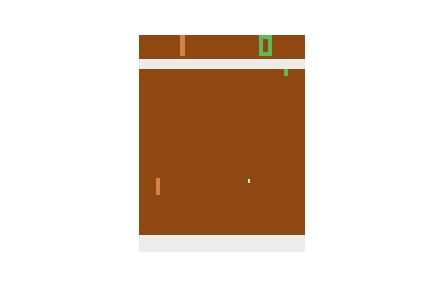
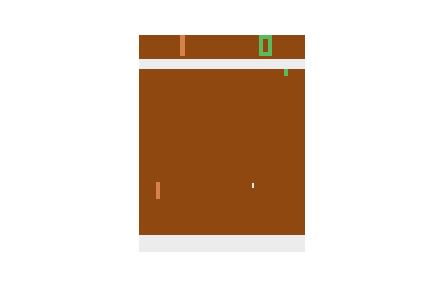
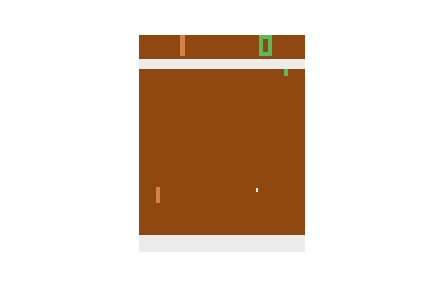
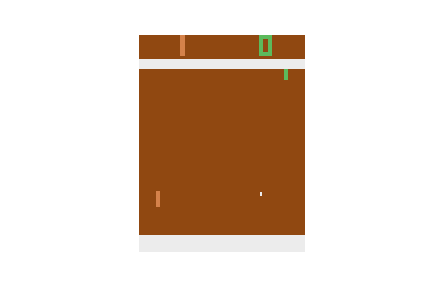
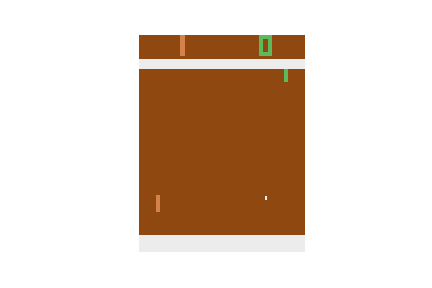
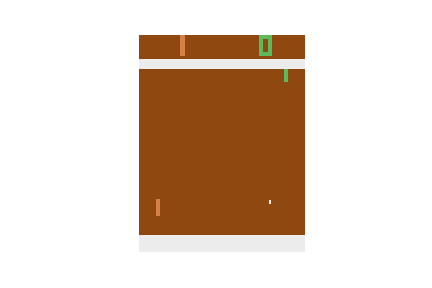
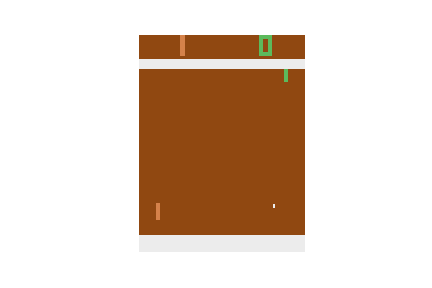
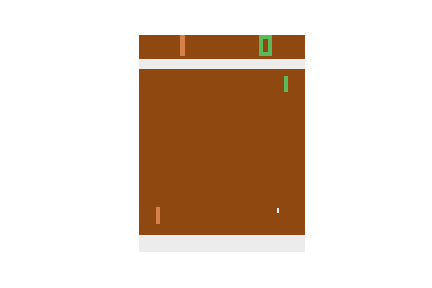
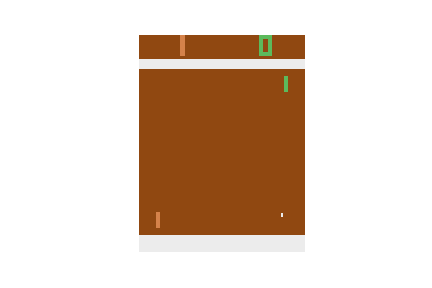
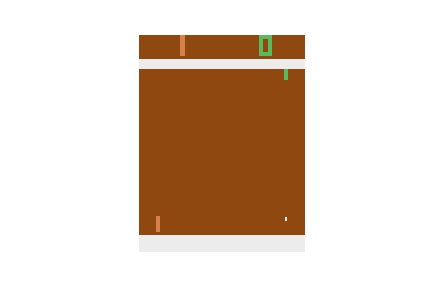
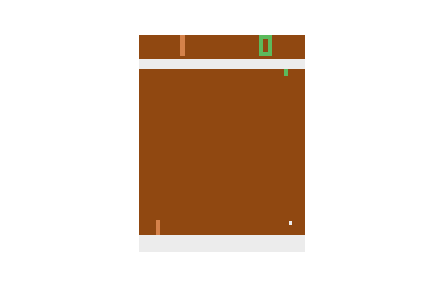
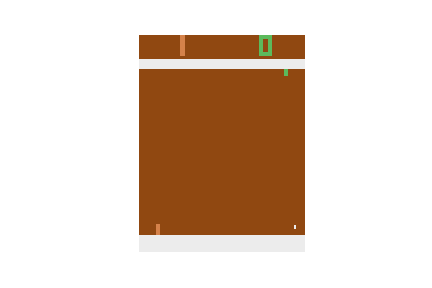
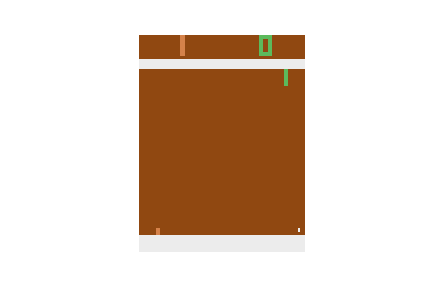
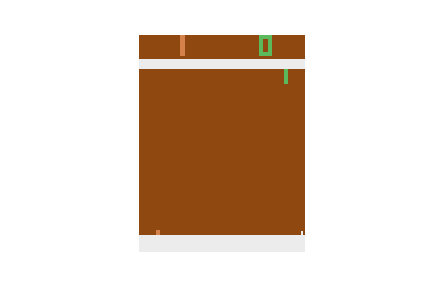
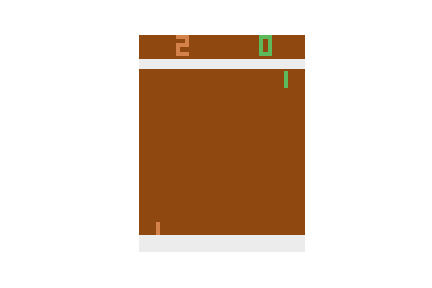
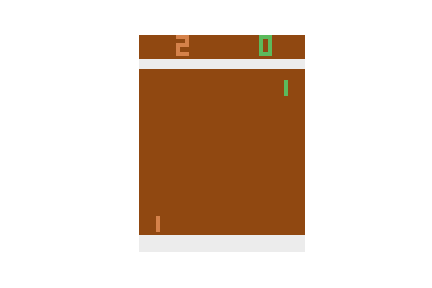
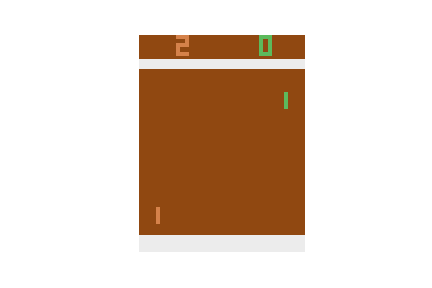
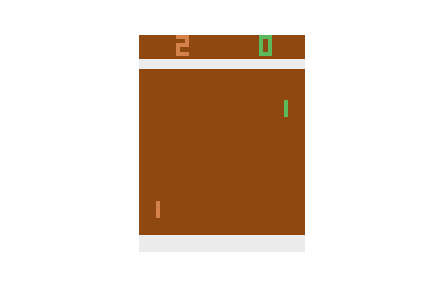
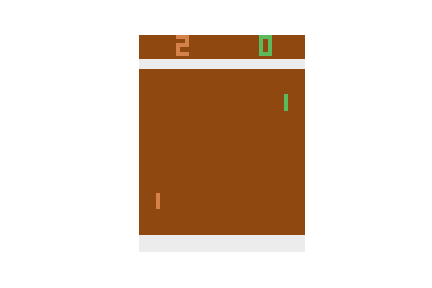
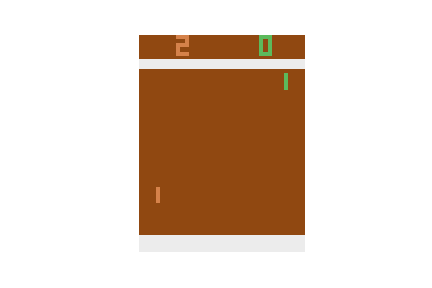
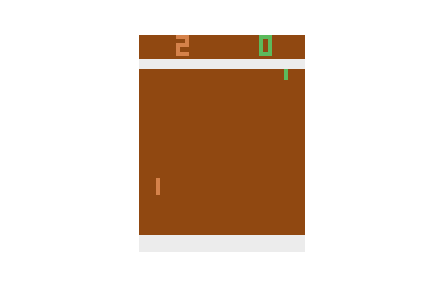
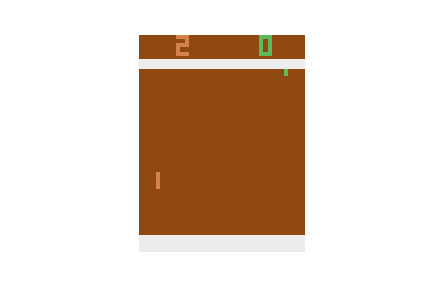
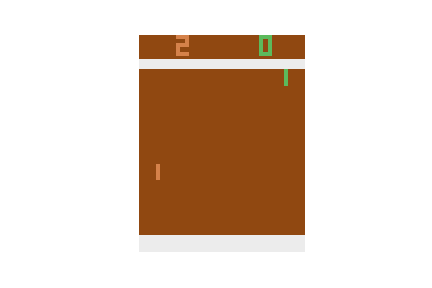
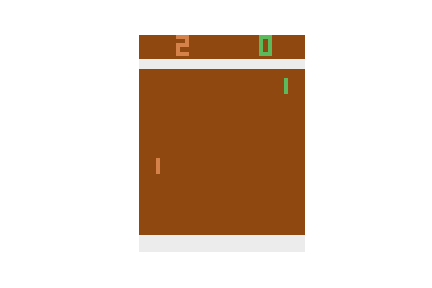
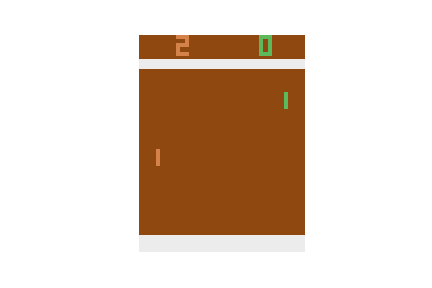
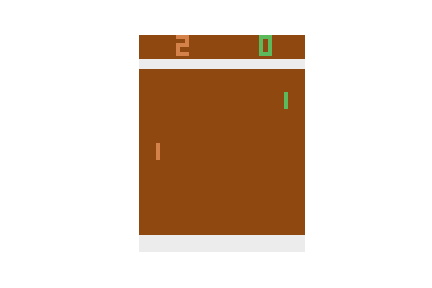
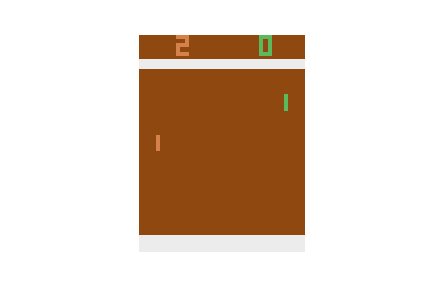
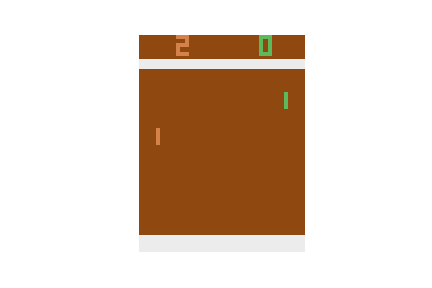
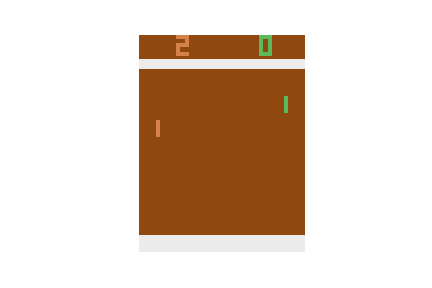
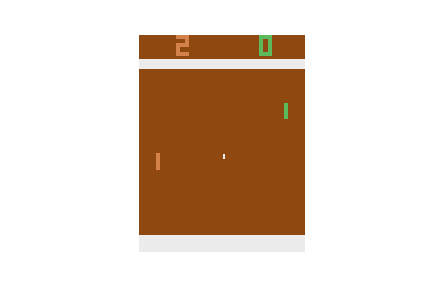
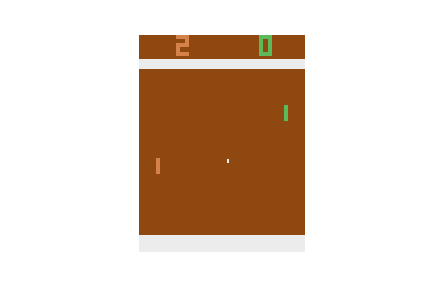
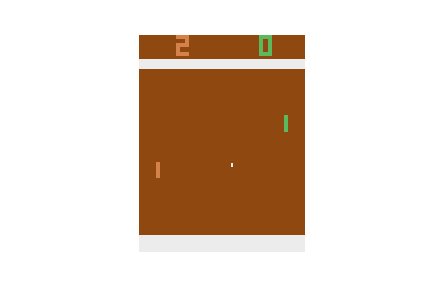
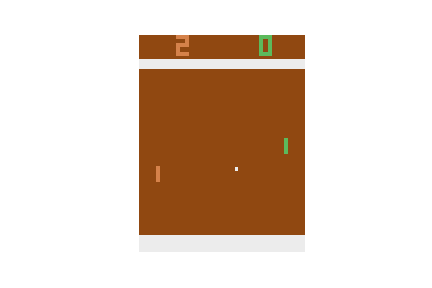
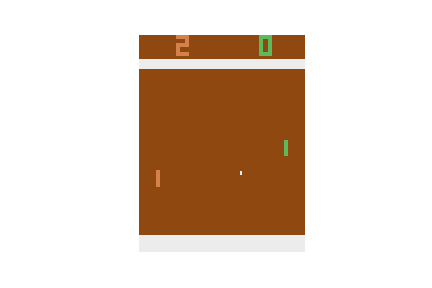
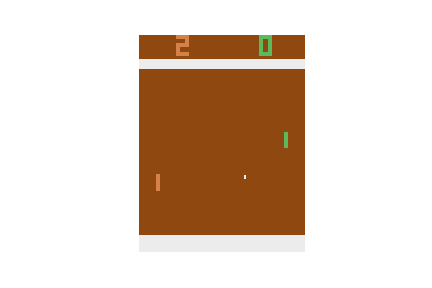
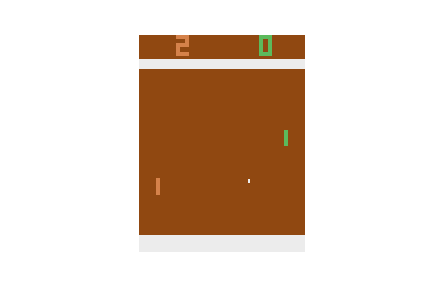
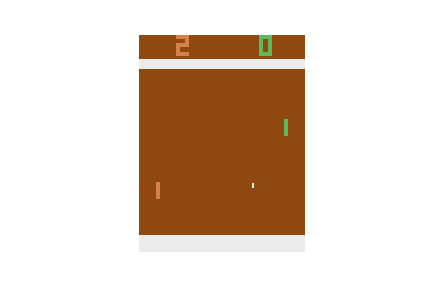
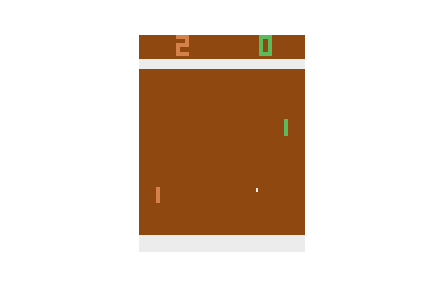
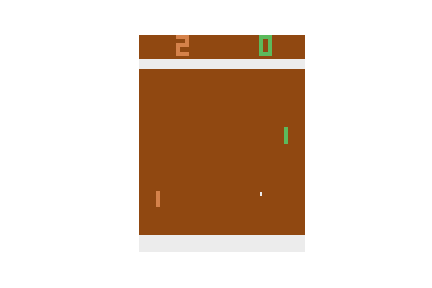
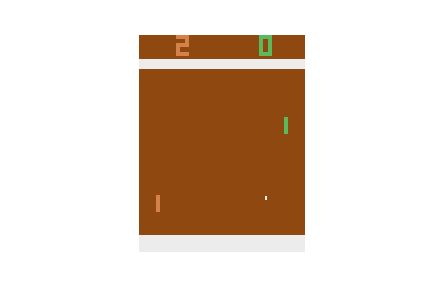
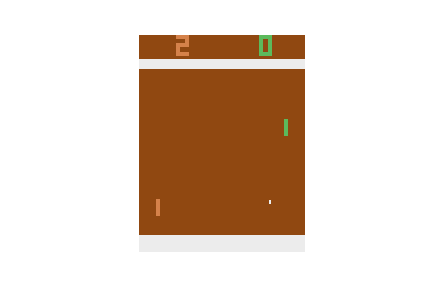
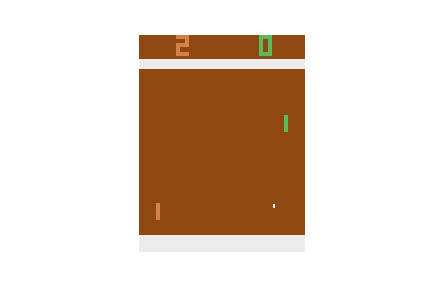
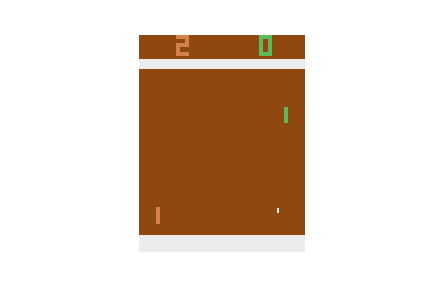
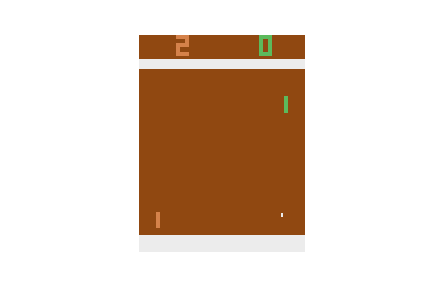
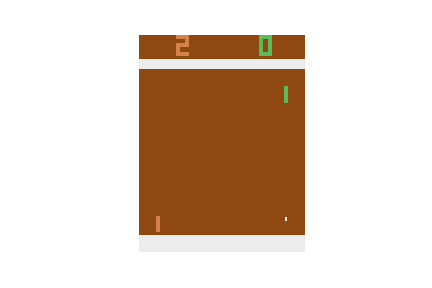
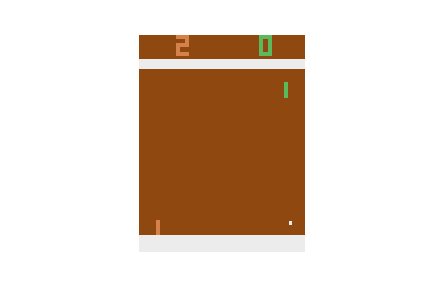
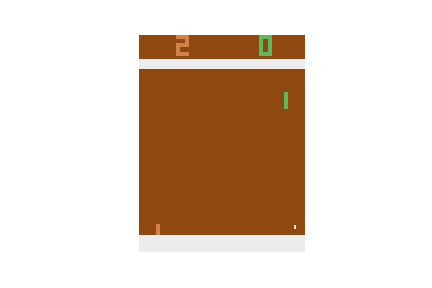
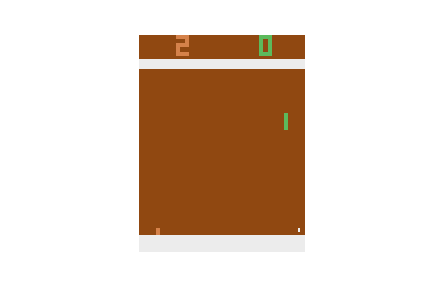
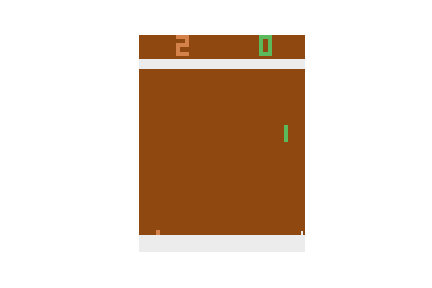
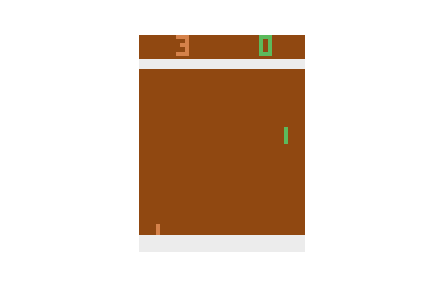
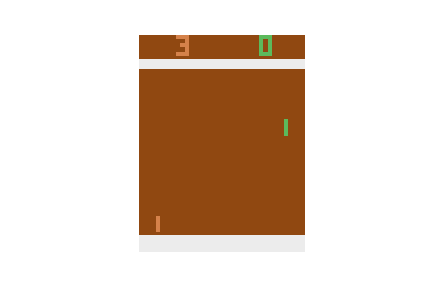
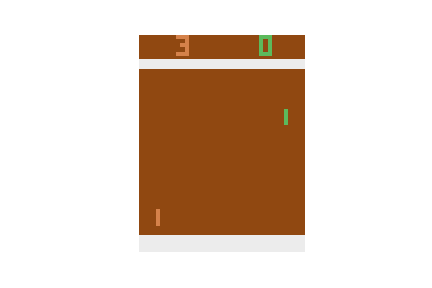
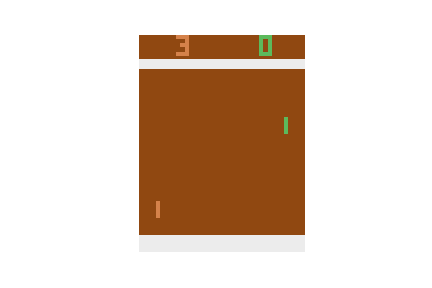
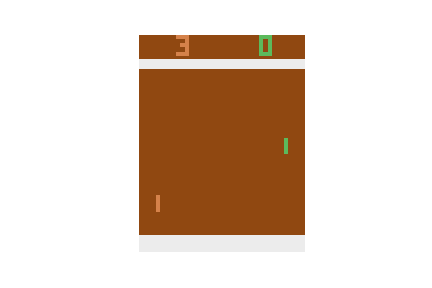
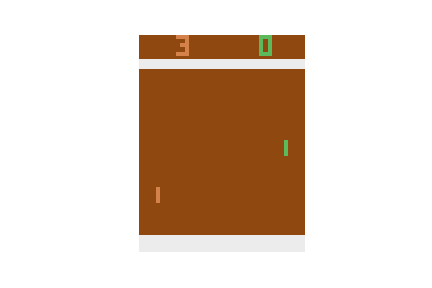
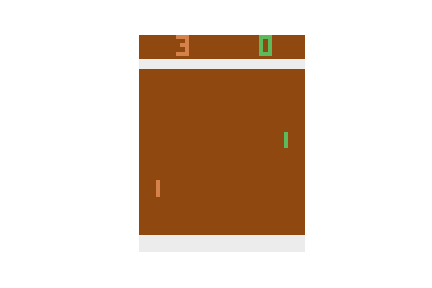
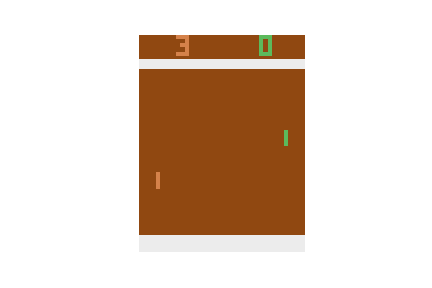
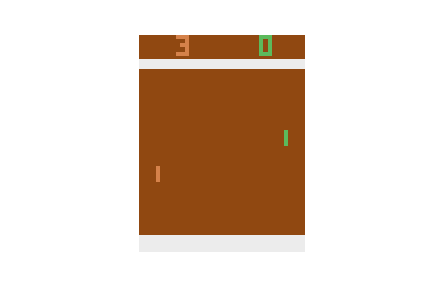
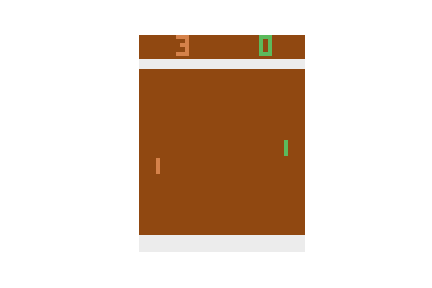
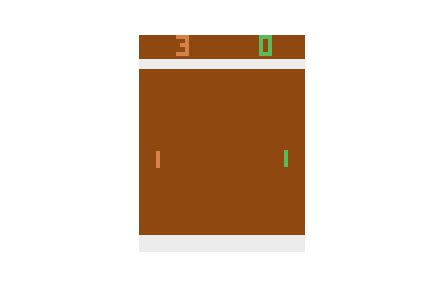
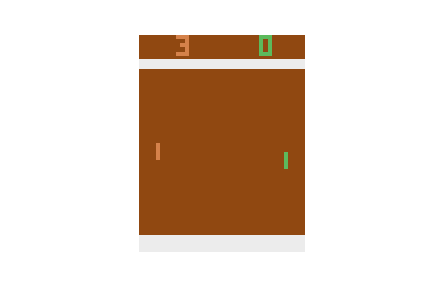
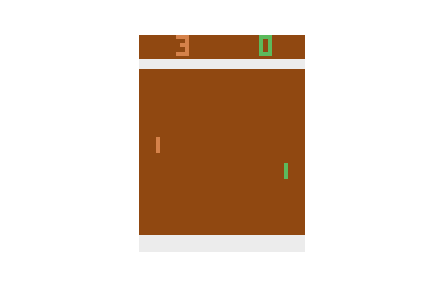
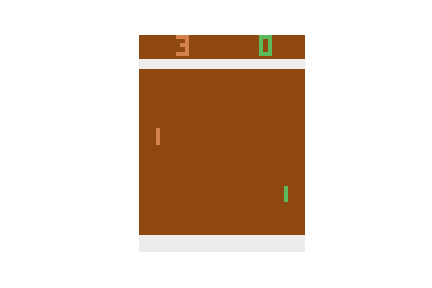
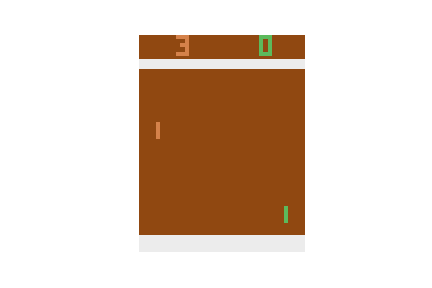
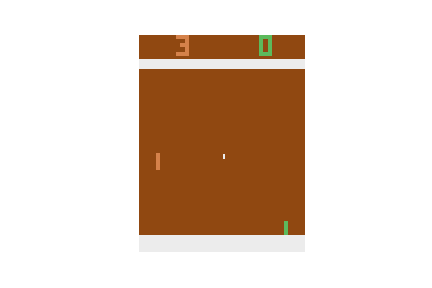
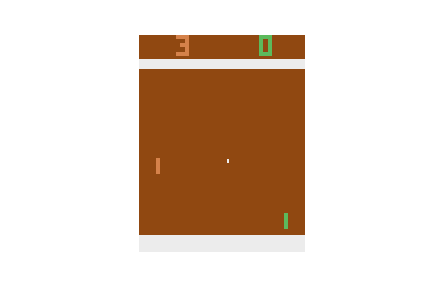
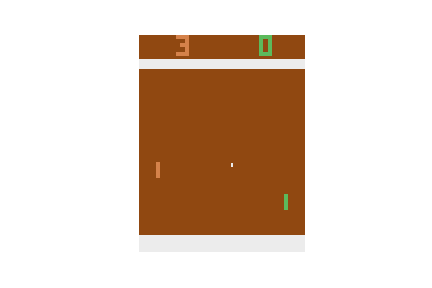
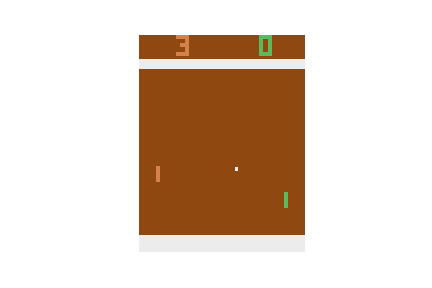
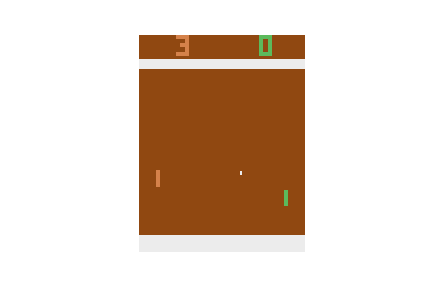
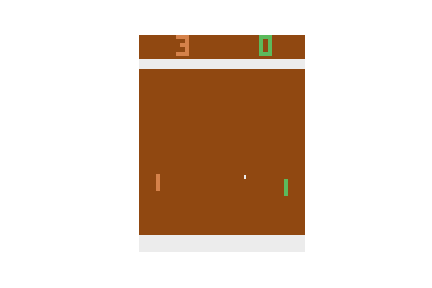
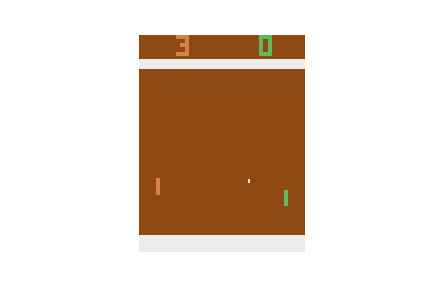
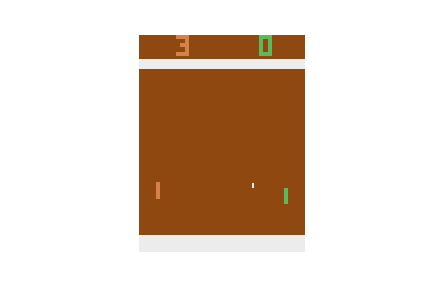
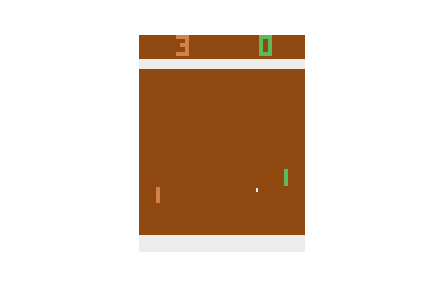
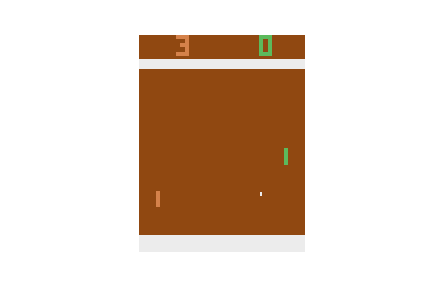
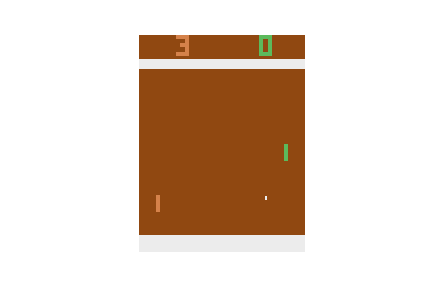
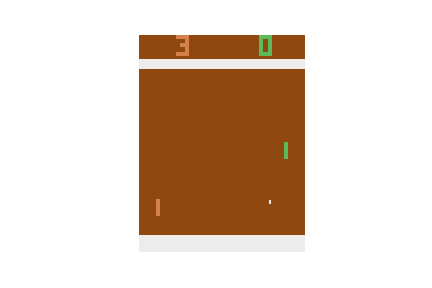
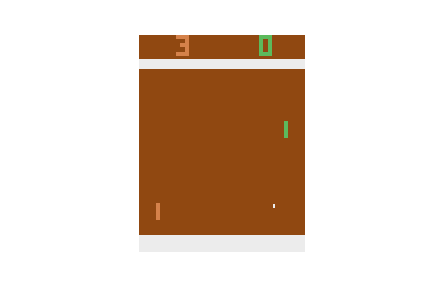
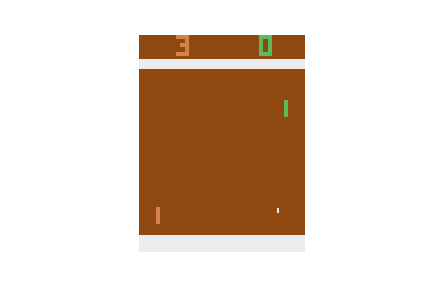
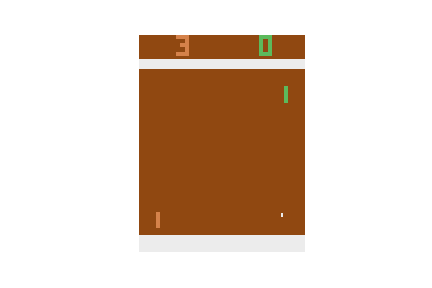
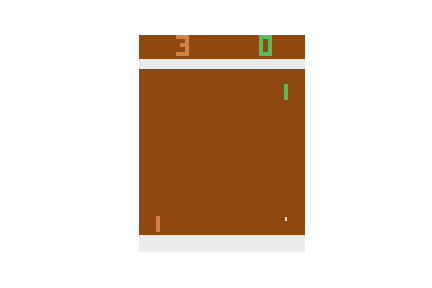
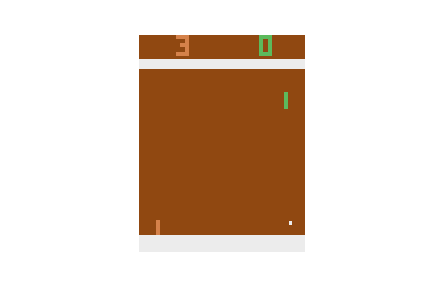
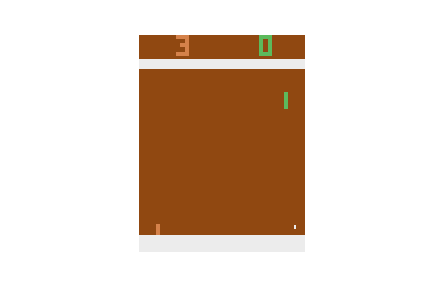
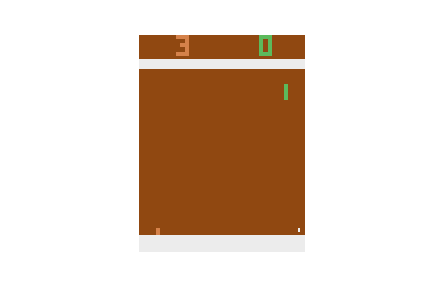
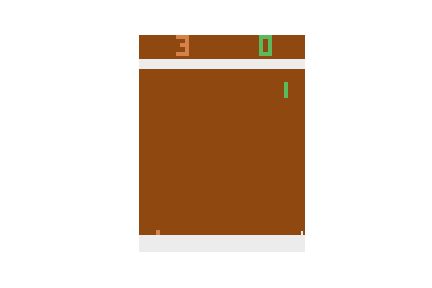
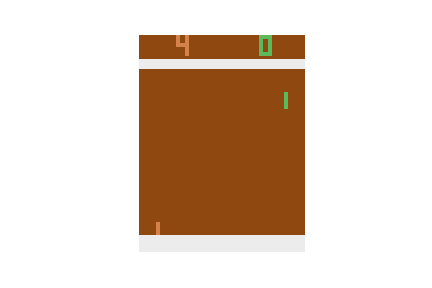
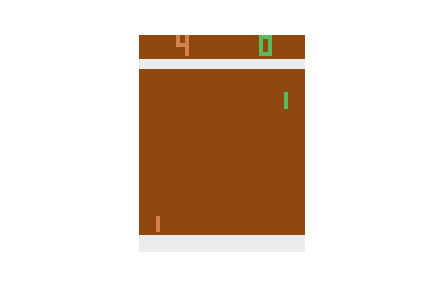
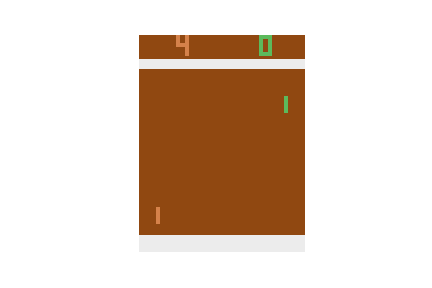
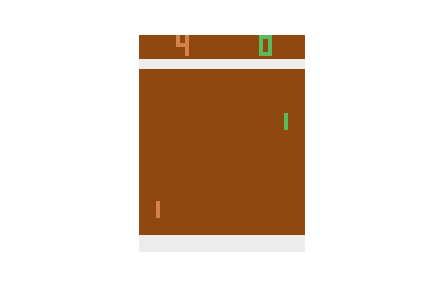
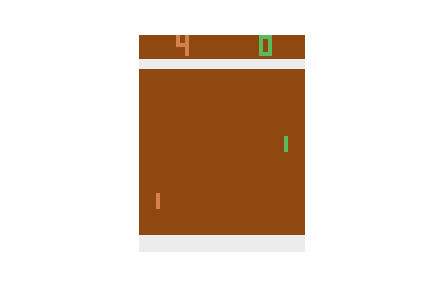
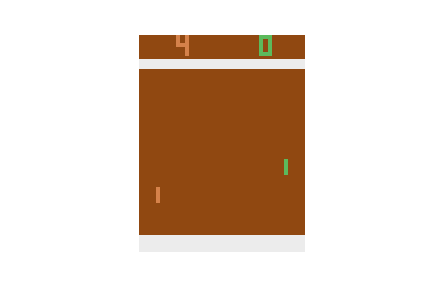
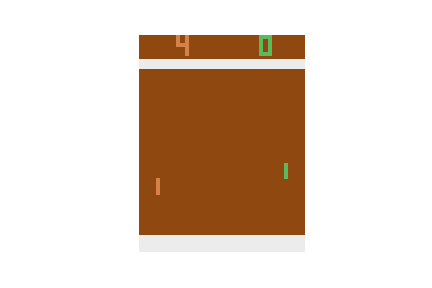
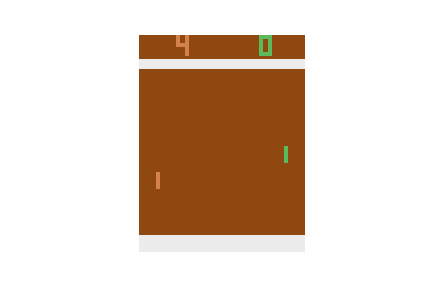
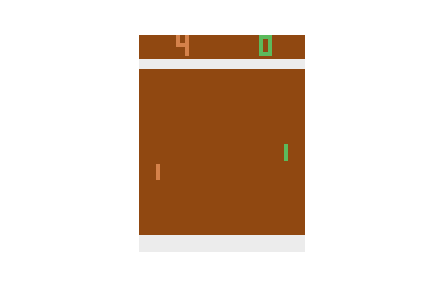
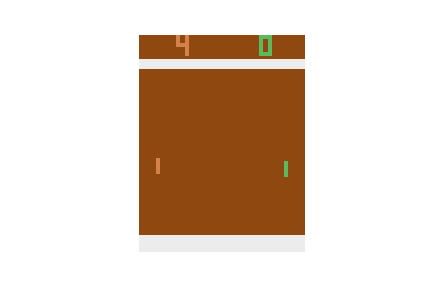
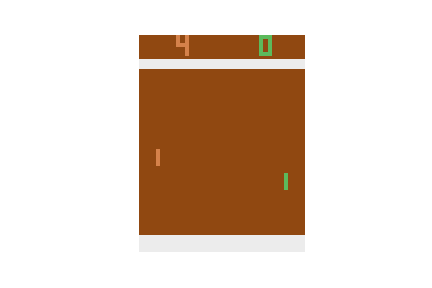
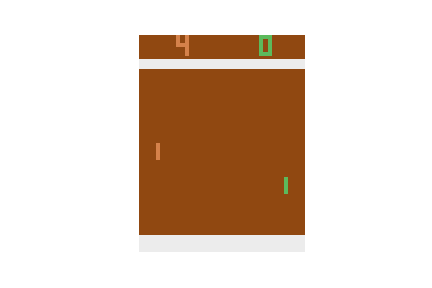
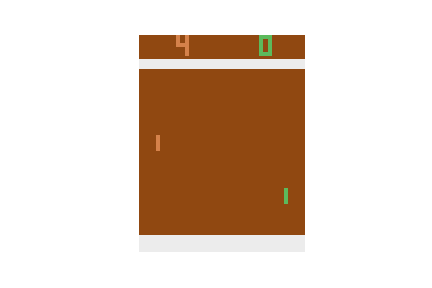
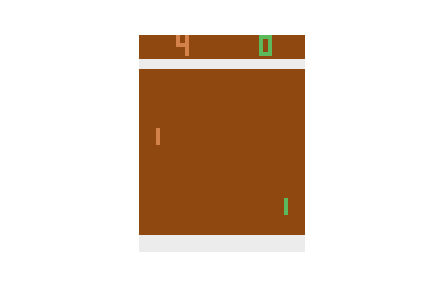
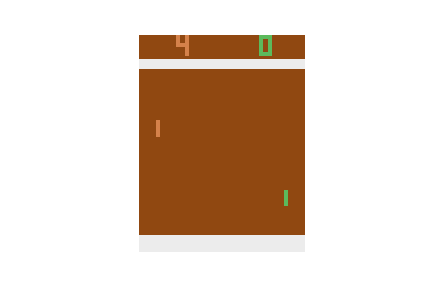
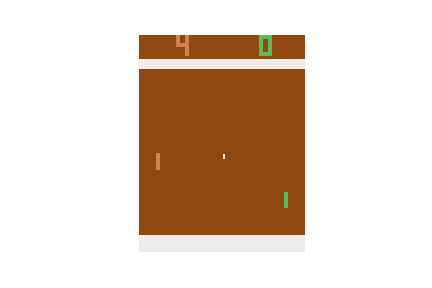
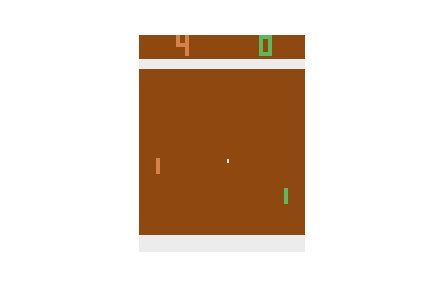
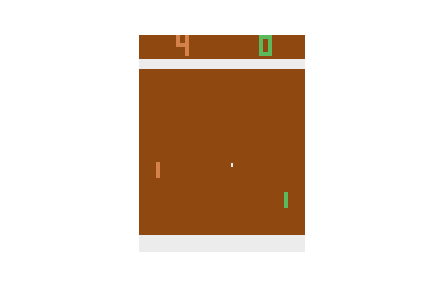
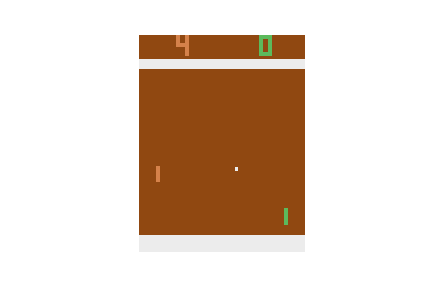
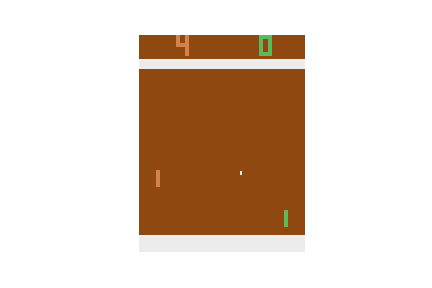
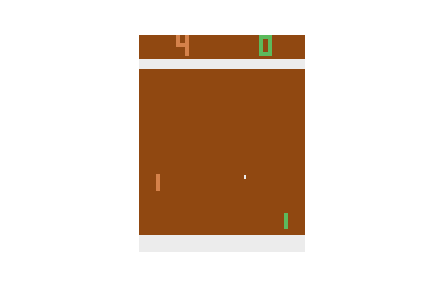
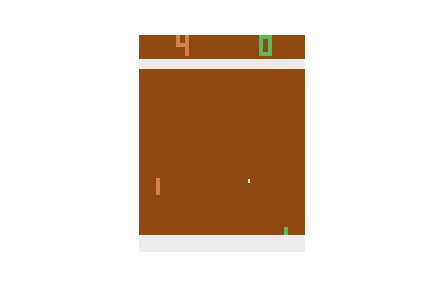
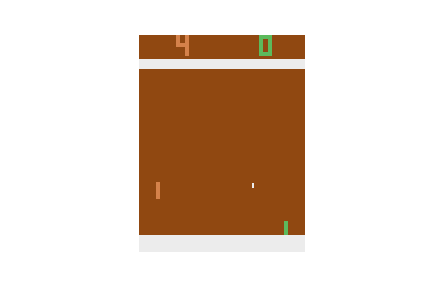
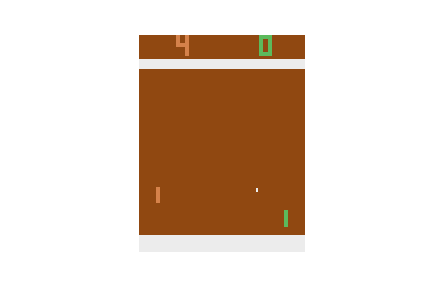
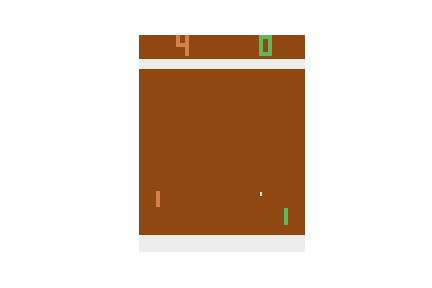
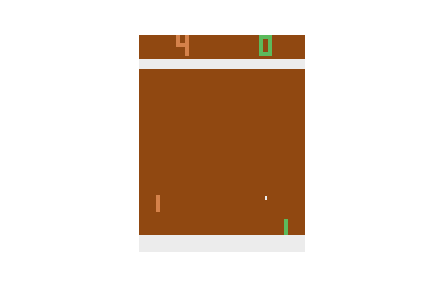
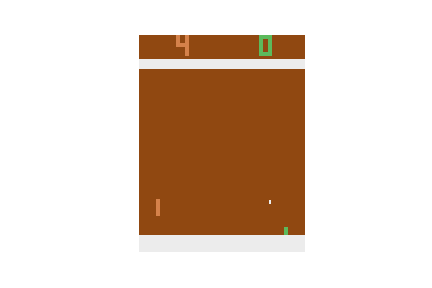
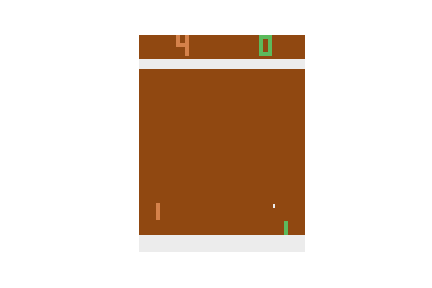
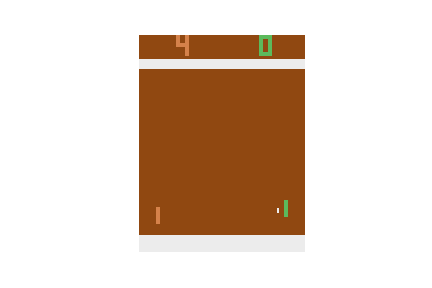
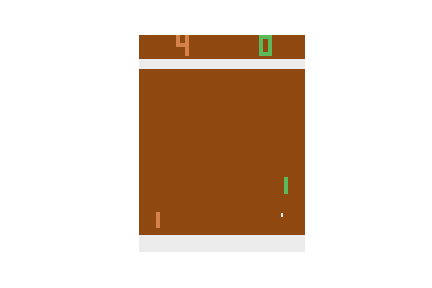
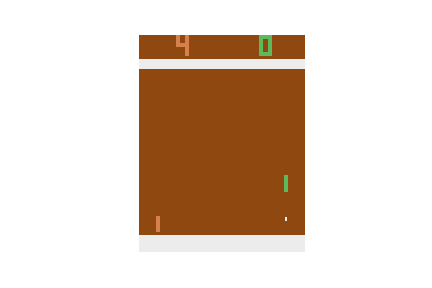
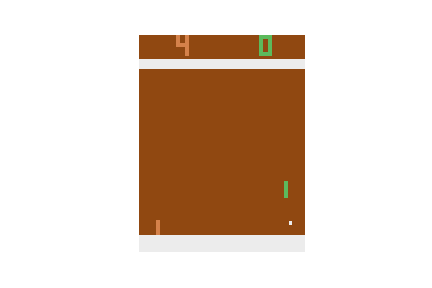
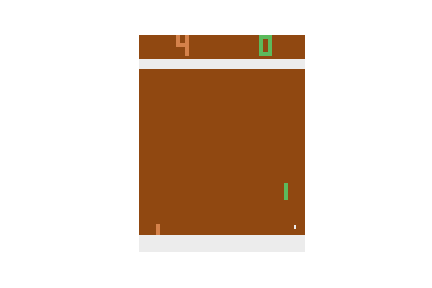
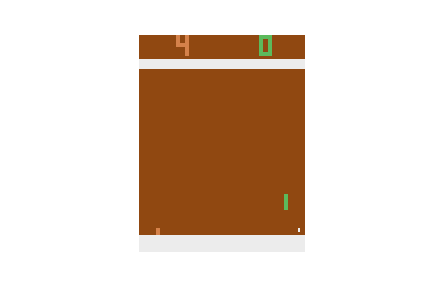
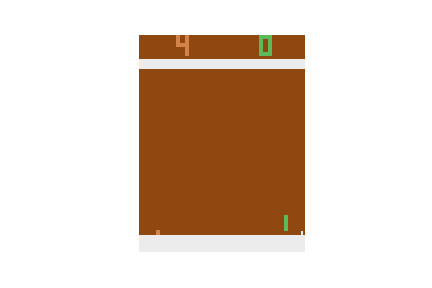
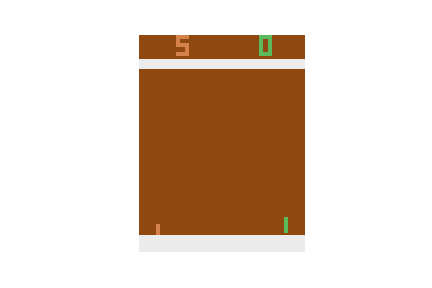
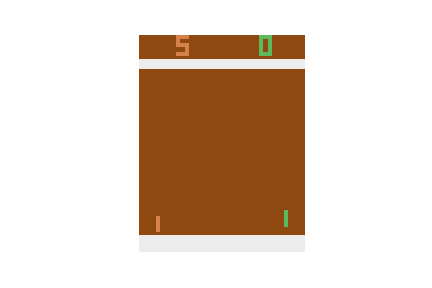
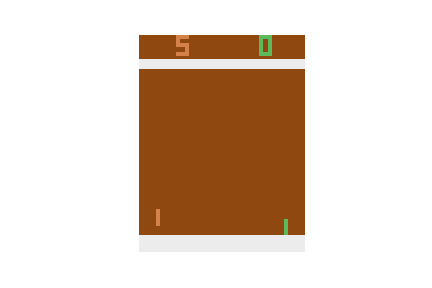
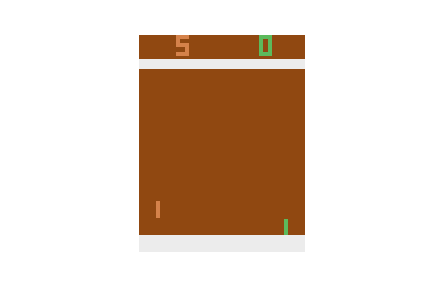
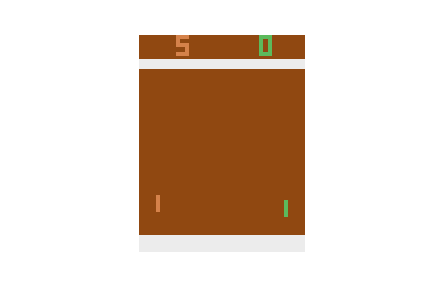
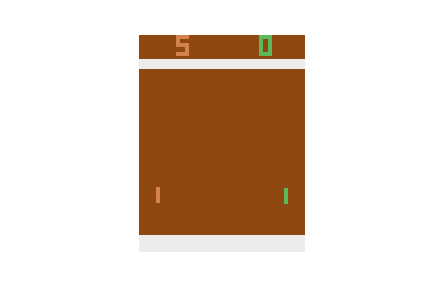
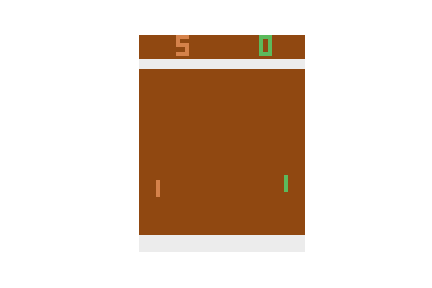
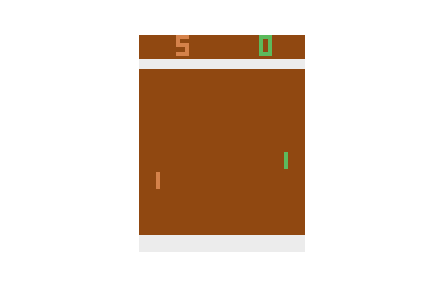
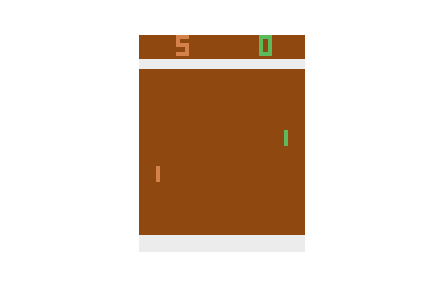
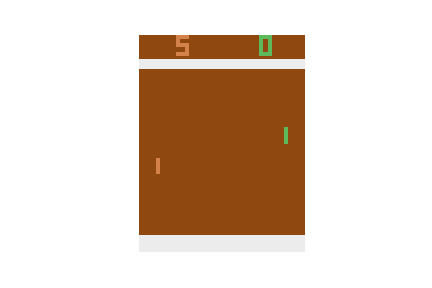
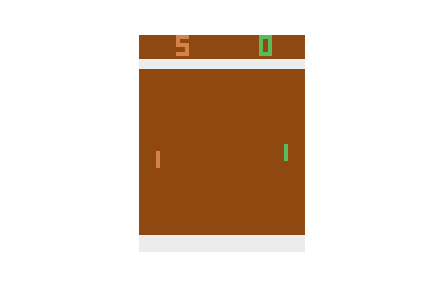
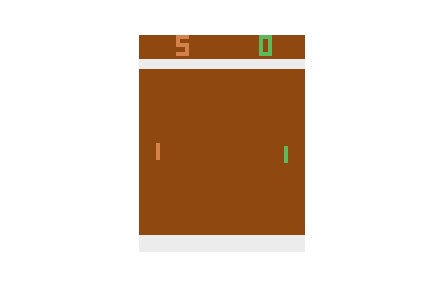
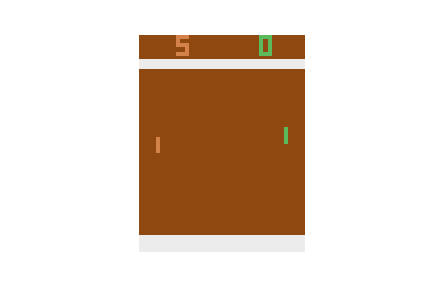
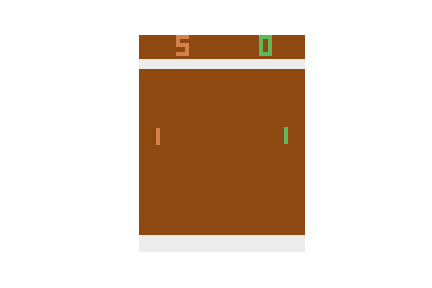
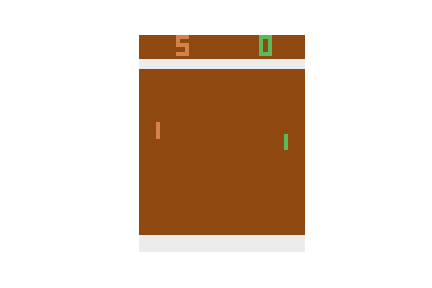
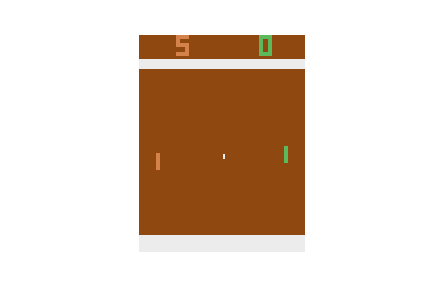
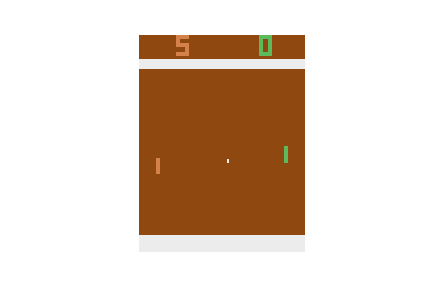
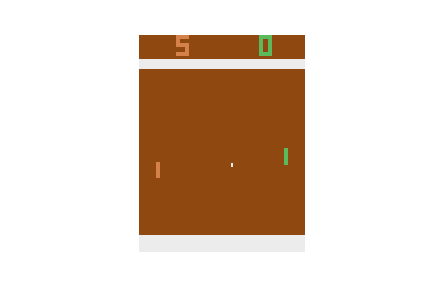
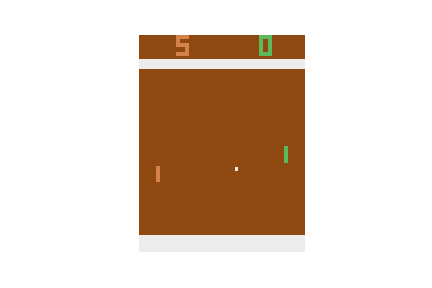
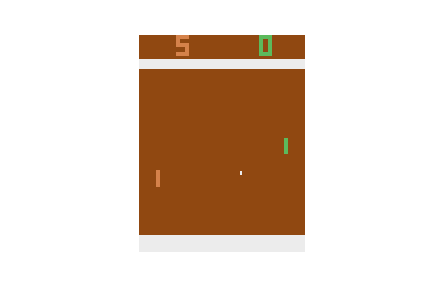
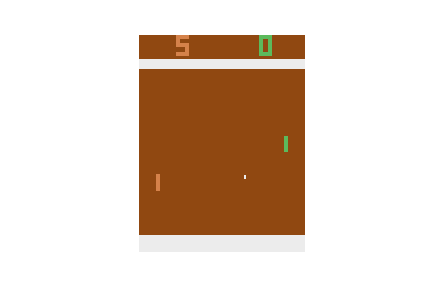
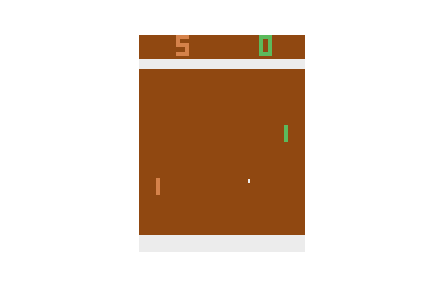
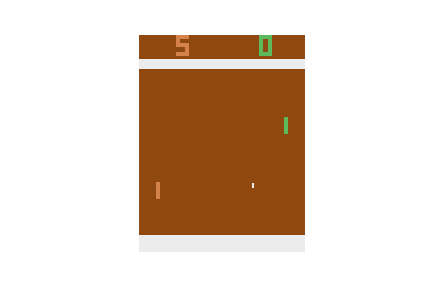
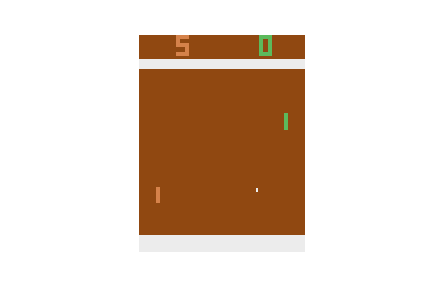
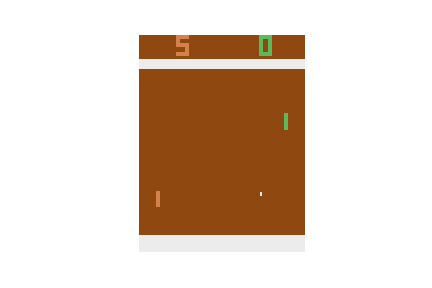
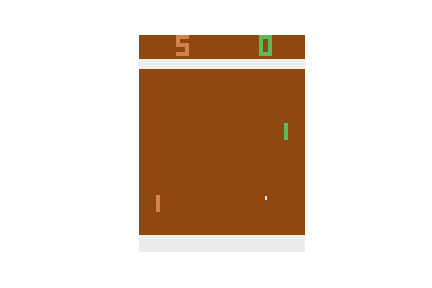
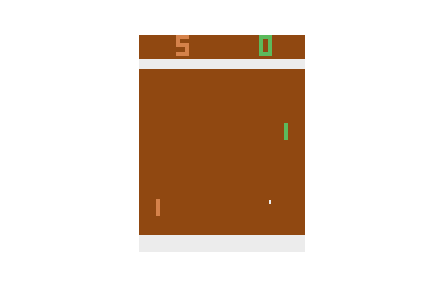
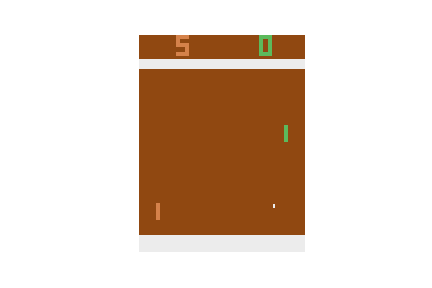
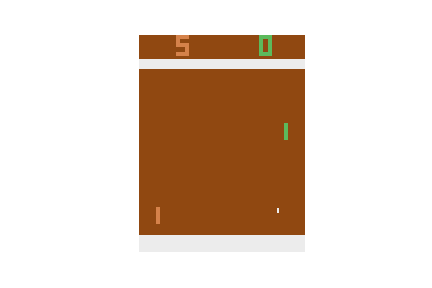
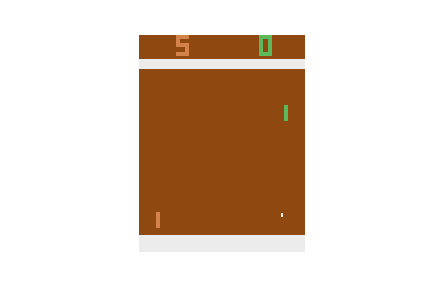
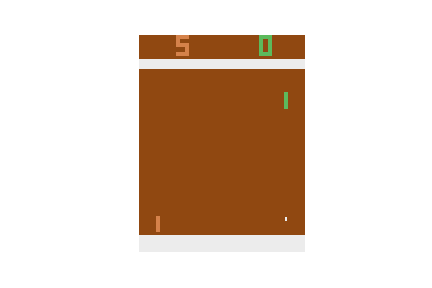
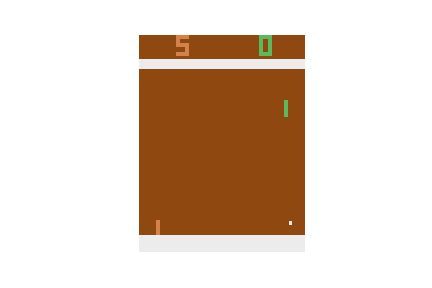
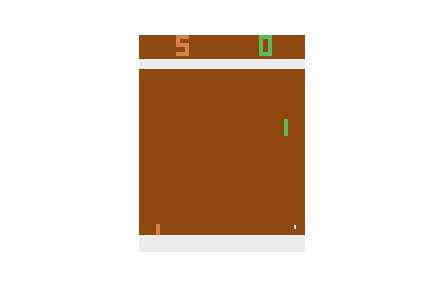
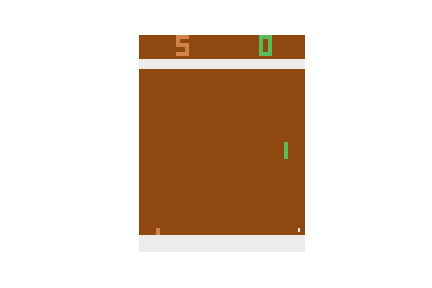
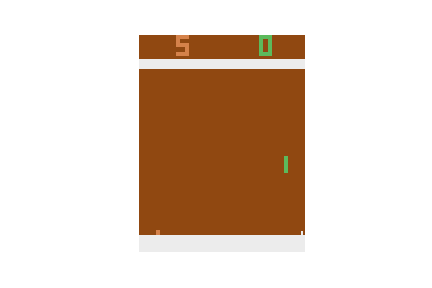
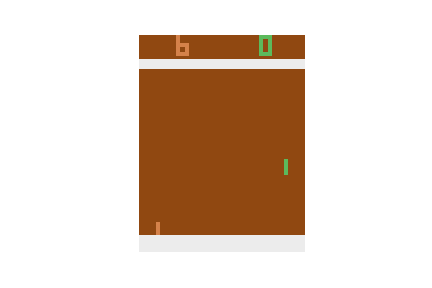
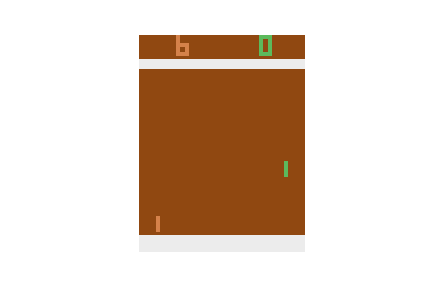
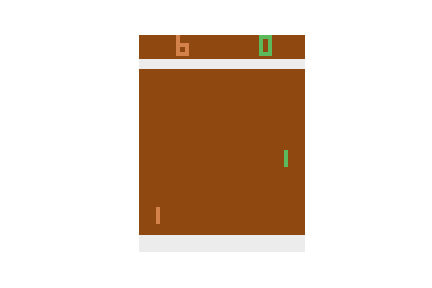
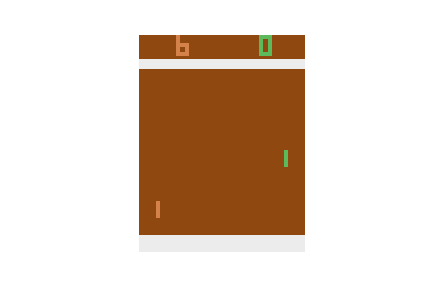
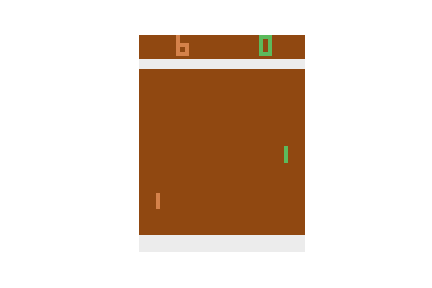
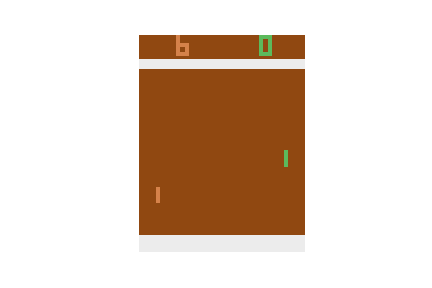
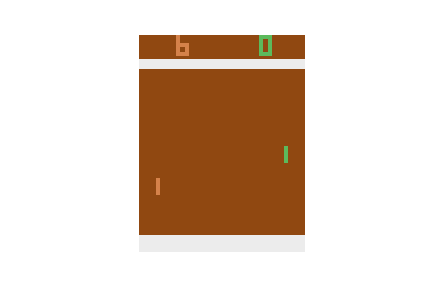
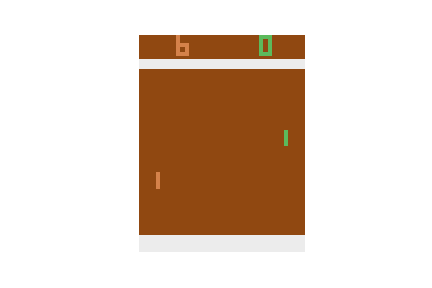
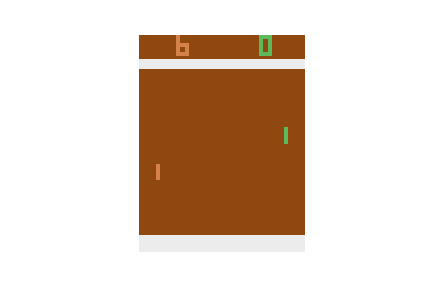
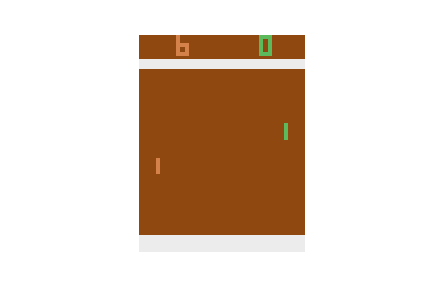
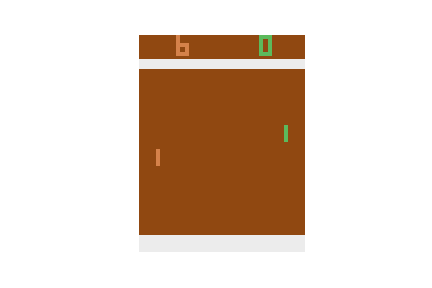
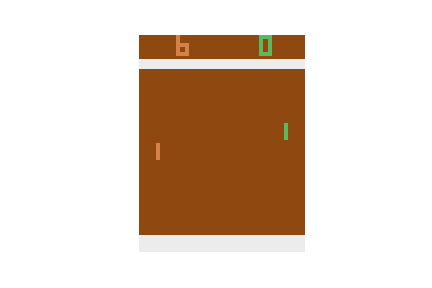
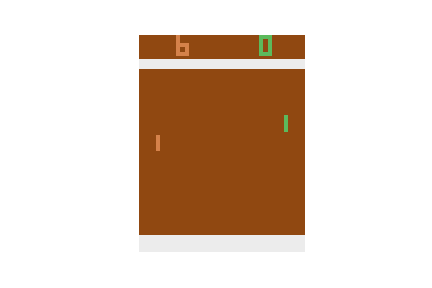
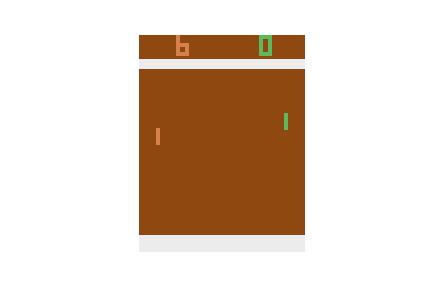
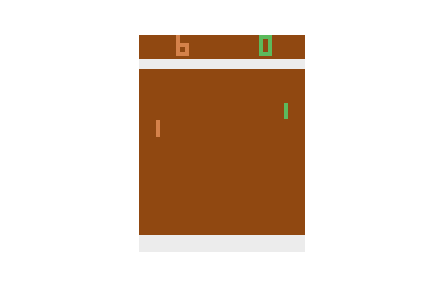
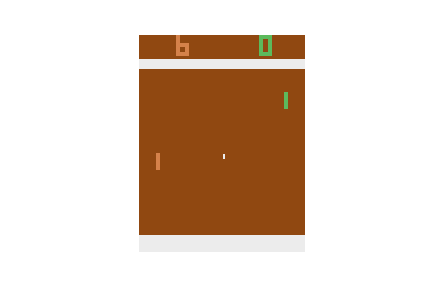
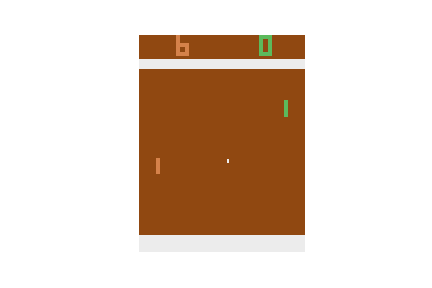
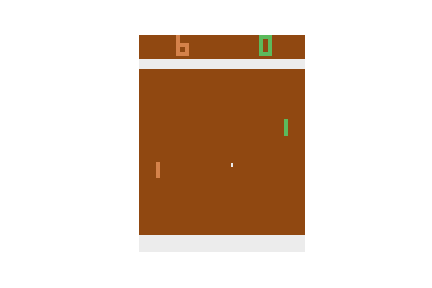
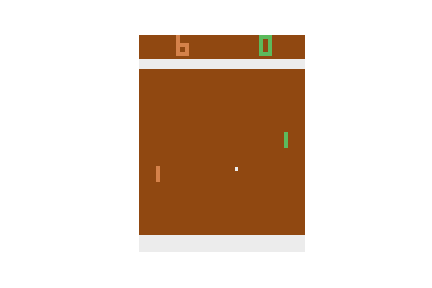
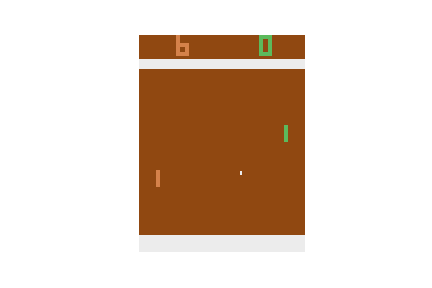
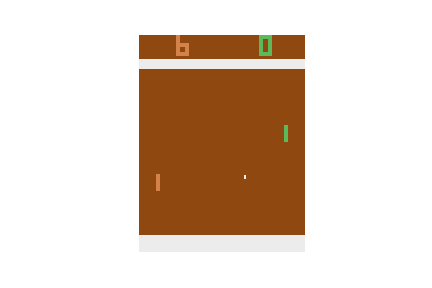
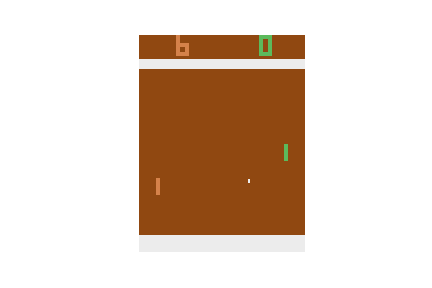
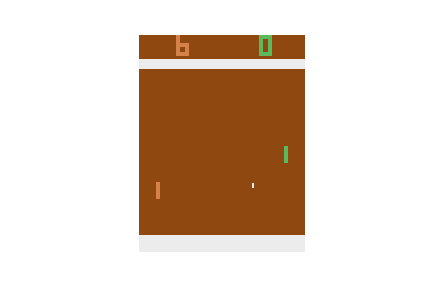
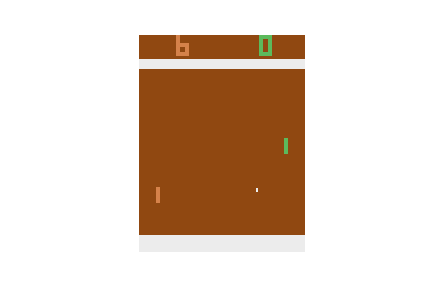
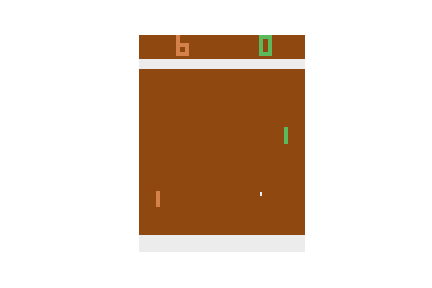
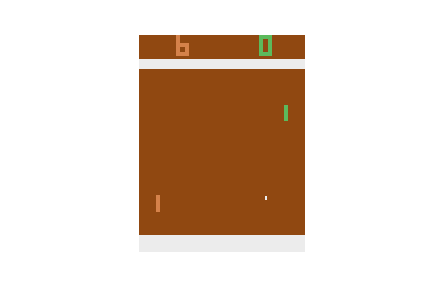
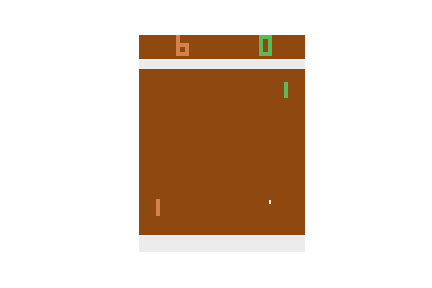
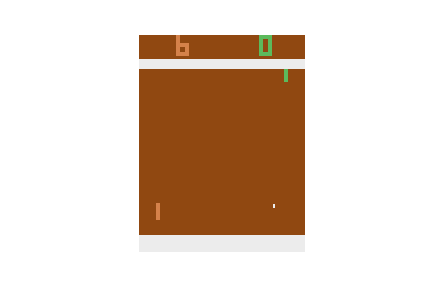
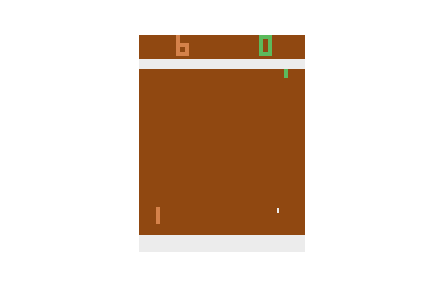
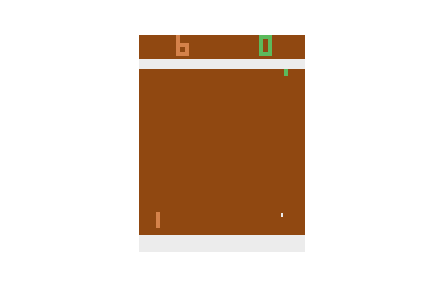
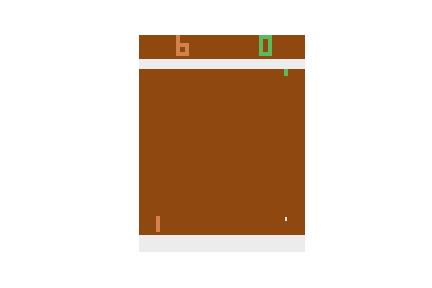
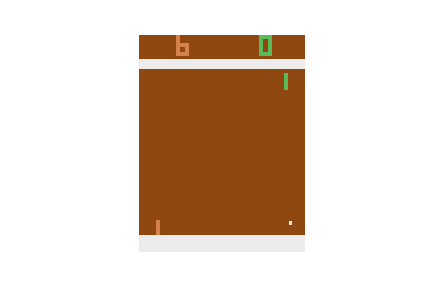

score: -6.0


In [10]:
from ppo_agent import Agent
from model import Actor, Critic

def create_actor():
    return Actor(action_dim=action_size)

def create_critic():
    return Critic()

agent = Agent(create_actor=create_actor, create_critic=create_critic)
score = play(env=env, agent=agent, t_max=320)
print(f"score: {score}")
# play(env=env, agent=agent, t_max=1000)

# PPO

## Exercise 2: implement PPO agent
you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [11]:
from ppo_agent import Agent
from model import Actor, Critic

def create_actor():
    return Actor(action_dim=action_size)

def create_critic():
    return Critic()


agent = Agent(
    create_actor=create_actor, 
    create_critic=create_critic,
    optimization_epochs=4, 
    discount=0.99,
    epsilon=0.1, 
    beta=0.01, 
    actor_lr=1e-4, 
    critic_lr=1e-4, 
    device=device)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [12]:
import progressbar as pb
from collections import deque
def train(envs, agent, episodes=1000, t_max=320, print_every=20):
    widget = ['training loop: ', pb.Percentage(), ' ',  pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

    scores = []
    scores_deque = deque(maxlen=100)
    for i_episode in range(1, episodes+1):
        states = envs.reset()
       
        action_probs, states, actions, rewards, next_states, dones = PongHelper.collect_trajectories(
            envs, agent, t_max=t_max)
        agent.learn(
            action_probs=action_probs,
            states=states,
            actions=actions,
            rewards=rewards,
            next_states=next_states,
            dones=dones)
        
        score = rewards.sum(axis=1)
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        print(f"\rEpisode {i_episode}/{episodes}",
              f"\tAverage Score: {np.mean(scores_deque):.2f}",
              f"\tScore: {np.mean(score):.2f}",
              f"\tMax Score: {np.max(scores_deque):.2f}",
              f"\tRewards:{score}", 
              end="")
        if i_episode % print_every == 0:
            timer.update(i_episode)
        
#         if (scores_deque[0]>30) and (np.mean(scores_deque) > 30):
        if np.mean(scores_deque) > 4:
            print(f"\nEnvironment solved in {i_episode-100} episodes!\t Average Score: {np.mean(scores_deque):.2f}")
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth') 
            break
    
    timer.finish()
    return scores

In [13]:
from task import ParallelTask

def create_env():
    return PongDeterministic()

envs = ParallelTask(create_env=create_env, n_tasks=8)
train(envs=envs, agent=agent)

Episode 19/1000 	Average Score: -6.58 	Score: -6.25 	Max Score: -4.88 	Rewards:[-6. -7. -8. -1. -8. -6. -7. -7.]

Episode 39/1000 	Average Score: -6.70 	Score: -7.25 	Max Score: -4.88 	Rewards:[-7. -6. -8. -7. -7. -7. -8. -8.]

Episode 59/1000 	Average Score: -6.72 	Score: -6.50 	Max Score: -4.88 	Rewards:[-5. -7. -8. -5. -7. -7. -8. -5.]

Episode 79/1000 	Average Score: -6.70 	Score: -6.50 	Max Score: -4.88 	Rewards:[-8. -4. -7. -5. -7. -8. -5. -8.]

Episode 99/1000 	Average Score: -6.67 	Score: -6.75 	Max Score: -4.88 	Rewards:[-5. -5. -7. -8. -6. -8. -8. -7.]

Episode 119/1000 	Average Score: -6.66 	Score: -6.50 	Max Score: -5.25 	Rewards:[-8. -6. -8. -4. -8. -7. -7. -4.]

Episode 139/1000 	Average Score: -6.63 	Score: -6.75 	Max Score: -5.25 	Rewards:[-5. -7. -8. -7. -5. -8. -8. -6.]

Episode 159/1000 	Average Score: -6.60 	Score: -6.00 	Max Score: -5.25 	Rewards:[-3. -7. -8. -7. -5. -5. -5. -8.]

Episode 179/1000 	Average Score: -6.62 	Score: -7.25 	Max Score: -5.25 	Rewards:[-7. -8. -8. -5. -7. -7. -8. -8.]

Episode 199/1000 	Average Score: -6.57 	Score: -7.50 	Max Score: -5.50 	Rewards:[-8. -7. -8. -8. -7. -6. -8. -8.]

Episode 219/1000 	Average Score: -6.63 	Score: -7.00 	Max Score: -5.50 	Rewards:[-8. -7. -7. -7. -8. -8. -6. -5.]

Episode 239/1000 	Average Score: -6.60 	Score: -6.25 	Max Score: -5.00 	Rewards:[-8. -5. -8. -8. -2. -6. -5. -8.]

Episode 259/1000 	Average Score: -6.61 	Score: -5.75 	Max Score: -4.50 	Rewards:[-8. -3. -4. -8. -5. -6. -4. -8.]

Episode 273/1000 	Average Score: -6.60 	Score: -7.12 	Max Score: -4.50 	Rewards:[-7. -8. -7. -8. -7. -5. -7. -8.]

Process EnvProcess-4:
Process EnvProcess-3:
Process EnvProcess-6:
Process EnvProcess-7:
Process EnvProcess-5:
Process EnvProcess-8:
Process EnvProcess-2:
Process EnvProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap

KeyboardInterrupt: 

### Watch Smart Agent

In [ ]:
from ppo_agent import Agent
from model import Actor, Critic

def create_actor():
    return Actor(action_dim=action_size)

def create_critic():
    return Critic()


agent = Agent(
    create_actor=create_actor, 
    create_critic=create_critic,
    optimization_epochs=4, 
    discount=0.99,
    epsilon=0.1, 
    beta=0.01, 
    actor_lr=1e-4, 
    critic_lr=1e-4, 
    device=device)

agent.actor.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic.load_state_dict(torch.load('checkpoint_critic.pth'))

play(env=env, agent=agent, t_max=1000)